<a href="https://colab.research.google.com/github/Layantt/Data-Science-Project/blob/main/DataScience.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 import os, re, pandas as pd
from pathlib import Path
from IPython.display import display
from google.colab import files
OUT = Path("raw_data"); OUT.mkdir(exist_ok=True)


In [ ]:
# Required Libraries Installation
import subprocess, sys, os, re
from datetime import datetime

def install_packages():
    packages = ["requests", "beautifulsoup4", "pandas", "lxml", "urllib3", "certifi"]
    for package in packages:
        try:
            __import__(package.replace("beautifulsoup4", "bs4"))
        except ImportError:
            subprocess.run([sys.executable, "-m", "pip", "install", package], check=True)

install_packages()

# Imports
import requests, pandas as pd
import certifi
from bs4 import BeautifulSoup
from google.colab import files
from pathlib import Path
import urllib3

# Disable only the SSL warning if we fall back to verify=False
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Output dir
output_dir = Path("raw_data")
output_dir.mkdir(exist_ok=True)
html_file = output_dir / "pdpl_raw_html.html"
csv_file  = output_dir / "pdpl_articles_enhanced.csv"

url = "https://laws.boe.gov.sa/boelaws/laws/lawdetails/b7cfae89-828e-4994-b167-adaa00e37188/1"
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36"}

print("Starting enhanced data collection with article status detection...")

def fetch_with_fallback(url, headers, timeout=30):
    """
    1) Try with default CA bundle (secure)
    2) Try with certifi.where() (explicit CA path)
    3) Last resort: verify=False (insecure, but pragmatic for Colab scraping)
    """
    try:
        r = requests.get(url, headers=headers, timeout=timeout)  # default
        r.raise_for_status()
        return r, "secure-default"
    except Exception as e1:
        try:
            r = requests.get(url, headers=headers, timeout=timeout, verify=certifi.where())
            r.raise_for_status()
            return r, "secure-certifi"
        except Exception as e2:
            # Final fallback (NOT for prod; just to proceed in Colab)
            r = requests.get(url, headers=headers, timeout=timeout, verify=False)
            r.raise_for_status()
            return r, "insecure-fallback"

try:
    response, mode = fetch_with_fallback(url, headers)
    print(f"HTTP GET OK via mode: {mode} | status={response.status_code}")

    # Save raw HTML for inspection
    html_file.write_text(response.text, encoding="utf-8")
    print(f"Raw HTML saved: {html_file}")

    soup = BeautifulSoup(response.text, "lxml")

    # Try structured extraction first
    articles_from_html = []
    article_divs = soup.find_all("div", class_="article_item")

    if article_divs:
        print(f"Found {len(article_divs)} article divs in HTML structure")
        for div in article_divs:
            classes = div.get("class", [])
            if "changed-article" in classes:
                article_status = "معدلة"
            elif "no_alternate" in classes:
                article_status = "أصلية"
            else:
                article_status = "غير محدد"

            title_element = div.find("h3")
            article_title = title_element.get_text(strip=True) if title_element else "عنوان غير محدد"

            content_div = div.find("div", class_="HTMLContainer")
            if content_div:
                article_text = content_div.get_text(separator=" ", strip=True)
                modification_text = "لا يوجد نص معدل"

                if article_status == "معدلة":
                    popup_div = div.find("div", class_="article_item_popup")
                    if popup_div:
                        popup_content = popup_div.find("div", class_="HTMLContainer")
                        if popup_content:
                            popup_text = popup_content.get_text(separator=" ", strip=True)
                            if popup_text and len(popup_text) > 10:
                                modification_text = popup_text
                        else:
                            popup_text = popup_div.get_text(separator=" ", strip=True)
                            if popup_text and len(popup_text) > 10:
                                modification_text = popup_text

                if article_text and len(article_text) > 10:
                    articles_from_html.append({
                        "article_title": article_title,
                        "article_text": article_text,
                        "article_status": article_status,
                        "modification_text": modification_text
                    })

    # Fallback to text parsing if needed
    articles_from_text = []
    if not articles_from_html:
        print("No structured HTML found, falling back to text extraction...")
        text = soup.get_text(separator="\n", strip=True)
        lines = text.split("\n")
        current_article, current_content, article_found = None, [], False

        for line in lines:
            line = line.strip()
            if not line:
                continue
            if re.match(r"^المادة\s+", line):
                if current_article and current_content and article_found:
                    article_text = " ".join(current_content).strip()
                    if len(article_text) > 10:
                        article_status = "أصلية"
                        modification_text = "لا يوجد نص معدل"
                        if any(ind in article_text for ind in ["عُدلت هذه المادة", "المرسوم الملكي", "بموجب", "معدلة"]):
                            article_status = "معدلة"
                            patterns = [
                                r'عُدلت هذه المادة.*?"(.*?)"',
                                r'بموجب.*?المرسوم الملكي.*?(.*?)(?:\.|$)',
                                r'لتكون بالنص الآتي.*?"(.*?)"'
                            ]
                            for pattern in patterns:
                                m = re.search(pattern, article_text, re.DOTALL)
                                if m:
                                    modification_text = m.group(1).strip()
                                    break
                            if modification_text == "لا يوجد نص معدل":
                                mod_start = article_text.find("عُدلت هذه المادة")
                                if mod_start != -1:
                                    modification_text = article_text[mod_start:mod_start+200] + "..."

                        articles_from_text.append({
                            "article_title": current_article,
                            "article_text": article_text,
                            "article_status": article_status,
                            "modification_text": modification_text
                        })
                current_article, current_content, article_found = line, [], True
            else:
                if current_article and article_found:
                    if len(line) <= 3:
                        continue
                    skip_line = False
                    if (line.startswith("تاريخ") or line.startswith("رقم") or
                        line.startswith("الجريدة الرسمية") or line.startswith("*") or line.startswith("-")):
                        skip_line = True
                    admin_only = ["تعديلات المادة", "مادة معدلة", "مادة ملغية"]
                    line_lower = line.lower()
                    for pat in admin_only:
                        if pat in line_lower and len(line) < 150 and line.count('.') <= 1:
                            skip_line = True
                            break
                    if not skip_line:
                        current_content.append(line)

        if current_article and current_content and article_found:
            article_text = " ".join(current_content).strip()
            if len(article_text) > 10:
                article_status = "أصلية"
                modification_text = "لا يوجد نص معدل"
                if any(ind in article_text for ind in ["عُدلت هذه المادة", "المرسوم الملكي", "بموجب", "معدلة"]):
                    article_status = "معدلة"
                    patterns = [
                        r'عُدلت هذه المادة.*?"(.*?)"',
                        r'بموجب.*?المرسوم الملكي.*?(.*?)(?:\.|$)',
                        r'لتكون بالنص الآتي.*?"(.*?)"'
                    ]
                    for pattern in patterns:
                        m = re.search(pattern, article_text, re.DOTALL)
                        if m:
                            modification_text = m.group(1).strip()
                            break
                    if modification_text == "لا يوجد نص معدل":
                        mod_start = article_text.find("عُدلت هذه المادة")
                        if mod_start != -1:
                            modification_text = article_text[mod_start:mod_start+200] + "..."

                articles_from_text.append({
                    "article_title": current_article,
                    "article_text": article_text,
                    "article_status": article_status,
                    "modification_text": modification_text
                })

    # Prefer HTML-based; else text-based; else empty
    articles = articles_from_html if articles_from_html else articles_from_text

    # Build DataFrame (even if empty, but with columns)
    cols = ["article_title", "article_text", "article_status", "modification_text"]
    df = pd.DataFrame(articles, columns=cols)

    # Basic cleaning
    if not df.empty:
        df = df[df["article_text"].astype(str).str.len() > 10]
        df = df.drop_duplicates(subset=["article_title"])
        first_articles = df[df["article_title"].astype(str).str.contains("المادة الأولى|المادة \\(1\\)|المادة ١", case=False, na=False, regex=True)]
        if len(first_articles) > 1:
            print("Detected duplicate first article - fixing...")
            best_first = first_articles.loc[first_articles["article_text"].str.len().idxmax()]
            df = df[~df["article_title"].str.contains("المادة الأولى|المادة \\(1\\)|المادة ١", case=False, na=False, regex=True)]
            df = pd.concat([pd.DataFrame([best_first]), df]).reset_index(drop=True)

    # Always write a CSV so Cell 2 never fails with FileNotFound
    df.to_csv(csv_file, index=False, encoding="utf-8-sig")
    print(f"Successfully extracted {len(df)} articles with status information!")
    print(f"Enhanced data saved to: {csv_file}")

    # Quick stats
    print("CWD:", Path.cwd())
    print("raw_data contents:", [p.name for p in output_dir.iterdir()])

    if not df.empty:
        print("\n Article Status Summary:")
        print("-" * 40)
        for status, count in df['article_status'].value_counts().items():
            print(f"• {status}: {count} مادة")

except Exception as e:
    # As a last resort, create an empty CSV with columns so Cell 2 won't crash
    print(f" Error in data collection: {e}")
    if not csv_file.exists():
        pd.DataFrame(columns=["article_title", "article_text", "article_status", "modification_text"]).to_csv(csv_file, index=False, encoding="utf-8-sig")
        print("Created empty CSV due to error, to keep the pipeline alive.")

print("\n Files saved in directory:", output_dir)
print(" Enhanced data collection completed (with fallbacks).")
try:
    files.download(str(html_file))
    files.download(str(csv_file))
except:
    print(" Files ready for download in the output directory")


Starting enhanced data collection with article status detection...
HTTP GET OK via mode: insecure-fallback | status=200
Raw HTML saved: raw_data/pdpl_raw_html.html
Found 43 article divs in HTML structure
Successfully extracted 43 articles with status information!
Enhanced data saved to: raw_data/pdpl_articles_enhanced.csv
CWD: /content
raw_data contents: ['pdpl_articles_enhanced.csv', 'pdpl_raw_html.html']

 Article Status Summary:
----------------------------------------
• معدلة: 24 مادة
• أصلية: 19 مادة

 Files saved in directory: raw_data
 Enhanced data collection completed (with fallbacks).


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# secondary data

In [ ]:
SOURCES = [
    "https://www.dlapiper.com/en/insights/publications/2024/02/saudi-arabias-new-personal-data-protection-law-in-force",
    "https://www.mdpi.com/2075-471X/14/4/47"
]

def build_secondary():
    data = [
        ["id","question","answer"],

        [1, "ما الهدف من تشريعات حماية البيانات؟",
         "حماية خصوصية الأفراد مع السماح للجهات باستخدام البيانات عند الحاجة وبشكل قانوني ومتناسب"],

        [2, "لماذا تسعى الدول لمواءمة أنظمة حماية البيانات مع المعايير العالمية؟",
         "لدعم الثقة العابرة للحدود واتباع الممارسات الدولية وضمان شفافية القطاعات مثل التأمين"],

        [3, "ما التحدي الذي تُحدثه التقنيات الرقمية في حماية البيانات؟",
         "إمكانية جمع وتخزين ومشاركة البيانات على نطاق واسع مما يزيد مخاطر إساءة الاستخدام"],

        [4, "ما المبدأ المستخدم لموازنة خصوصية الأفراد واحتياجات الجهات؟",
         "اختبار الضرورة والتناسب الذي يقيم مدى الحاجة الفعلية للمعالجة وملاءمتها للخصوصية"],

        [5, "لماذا تعد الشفافية أساسية في قطاع التأمين؟",
         "لأن القطاع يعتمد على البيانات الشخصية والحساسة، والشفافية تعزز ثقة المتعاملين"],

        [6, "ما سبب تعقيد مسألة الموافقة في التأمين الإلزامي؟",
         "لأن الفرد مضطر لتقديم بياناته للحصول على خدمة إلزامية، ما يجعل الموافقة غير اختيارية تمامًا"],

        [7, "لماذا تحصل البيانات الحساسة على مستوى حماية أعلى؟",
         "لأن إساءة استخدامها قد تؤثر بشدة على سلامة الفرد وكرامته وفرصه"],

        [8, " متى دخل نظام حماية البيانات الشخصية حيز التنفيذ في السعودية؟(PDPL) ",
         "دخل النظام حيز التنفيذ في 14 سبتمبر 2023 مع فترة تكيّف مدتها 12 شهرًا"],

        [9, "هل يتطلب نظام إجراء تقييم مخاطر لنقل البيانات؟PDPL ",
         "نعم، يجب على المتحكمين إجراء تقييم لمخاطر النقل خصوصًا عند نقل بيانات حساسة أو نقلها بشكل مستمر"],

        [10, " ؟ PDPL ما الأسس النظامية لمعالجة البيانات بموجب ",
         "منها مبدأ المصلحة المشروعة، لكنه لا ينطبق على معالجة البيانات الحساسة"],

        [11, " ؟PDPL هل يجب على الجهات التسجيل لدى جهة سعودية بموجب نظام ",
         "قد يُطلب من الجهات التسجيل لدى الهيئة السعودية للبيانات والذكاء الاصطناعي (سدايا)، مع صدور قواعد لاحقة تحدد الفئات الملزمة"],

        [12, "متى يجب إخطار صاحب البيانات عند حدوث تسريب؟",
         "يجب إخطار صاحب البيانات “دون تأخير غير مبرر” بحسب تفاصيل التسريب"],

        [13, "ما عقوبة الإفشاء المتعمد أو النشر الضار للبيانات الحساسة؟",
         "سنتان كحد أقصى للسجن أو غرامة تصل إلى 3 ملايين ريال سعودي"],

        [14, " ؟PDPL ما الحد الأقصى للغرامة الإدارية بموجب نظام ",
         "غرامة تصل إلى 5 ملايين ريال سعودي للانتهاكات غير الجنائية، وقد تتضاعف هذه الغرامات في حال تكرار المخالفة"],

        [15, "ما المخاطر الناتجة عن الاختيار العكسي في التأمين؟",
         "يمكن أن يؤدي إلى عدم التوازن حيث يمتلك طرف معرفة أكثر من الآخر، ما يخلق مزايا تفاوضية أو تسعيرية غير عادلة"],

        [16, "لماذا تعتبر البيانات الجينية من أصعب الفئات تنظيمًا؟",
         "لأنها تكشف معلومات شخصية وعائلية عميقة، يمكن أن تتنبأ بالنتائج الصحية المستقبلية، وتثير صدامات بين الخصوصية الفردية وأهداف الصحة العامة أو البحث"],

        [17, "لماذا يصعب تقييم النجاح طويل الأمد للقوانين الجديدة لحماية البيانات؟",
         "لأن التقييم الفعّال يتطلب سنوات من بيانات التطبيق مثل حالات التسريب والعقوبات وأنماط الامتثال الفعلية"]
    ]

    header, rows = data[0], data[1:]

    def clean(x):
        x = str(x).strip()
        x = re.sub(r"[^\w\s\u0600-\u06FF\-\–\—.,;؟?!%()«»]+", "", x)
        return re.sub(r"\s+", " ", x)

    cleaned = [[clean(v) for v in r] for r in rows]

    df_secondary = pd.DataFrame(cleaned, columns=header)

    path = OUT / "pdpl_secondary_nonofficial.csv"
    df_secondary.to_csv(path, index=False, encoding="utf-8-sig")

    display(df_secondary)
    files.download(str(path))

    print("saved ", path)
    return df_secondary


df_secondary = build_secondary()




,id,question,answer
0,1,ما الهدف من تشريعات حماية البيانات؟,حماية خصوصية الأفراد مع السماح للجهات باستخدام...
1,2,لماذا تسعى الدول لمواءمة أنظمة حماية البيانات ...,لدعم الثقة العابرة للحدود واتباع الممارسات الد...
2,3,ما التحدي الذي تُحدثه التقنيات الرقمية في حماي...,إمكانية جمع وتخزين ومشاركة البيانات على نطاق و...
3,4,ما المبدأ المستخدم لموازنة خصوصية الأفراد واحت...,اختبار الضرورة والتناسب الذي يقيم مدى الحاجة ا...
4,5,لماذا تعد الشفافية أساسية في قطاع التأمين؟,لأن القطاع يعتمد على البيانات الشخصية والحساسة...
5,6,ما سبب تعقيد مسألة الموافقة في التأمين الإلزامي؟,لأن الفرد مضطر لتقديم بياناته للحصول على خدمة ...
6,7,لماذا تحصل البيانات الحساسة على مستوى حماية أعلى؟,لأن إساءة استخدامها قد تؤثر بشدة على سلامة الف...
7,8,متى دخل نظام حماية البيانات الشخصية حيز التنفي...,دخل النظام حيز التنفيذ في 14 سبتمبر 2023 مع فت...
8,9,هل يتطلب نظام إجراء تقييم مخاطر لنقل البيانات؟...,نعم، يجب على المتحكمين إجراء تقييم لمخاطر النق...
9,10,؟ PDPL ما الأسس النظامية لمعالجة البيانات بموجب,منها مبدأ المصلحة المشروعة، لكنه لا ينطبق على ...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

saved  raw_data/pdpl_secondary_nonofficial.csv


# Data Processing and Cleaning

In [ ]:
from pathlib import Path
import pandas as pd

base = Path("raw_data")
print("CWD:", Path.cwd())
print("raw_data contents:", [p.name for p in base.glob("*")])

target = base / "pdpl_articles_enhanced.csv"
if not target.exists():
    raise FileNotFoundError("CSV not found. Re-run Cell 1 successfully first.")

# ترميز utf-8-sig
df = pd.read_csv(target, encoding="utf-8-sig")
print("Loaded file:", target)
print("Initial shape:", df.shape)
df.info()

# checking out
display(df.head(2))


CWD: /content
raw_data contents: ['pdpl_articles_enhanced.csv', 'pdpl_secondary_nonofficial.csv', 'pdpl_raw_html.html']
Loaded file: raw_data/pdpl_articles_enhanced.csv
Initial shape: (43, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   article_title      43 non-null     object
 1   article_text       43 non-null     object
 2   article_status     43 non-null     object
 3   modification_text  43 non-null     object
dtypes: object(4)
memory usage: 1.5+ KB


,article_title,article_text,article_status,modification_text
0,المادة الأولى,لغرض تطبيق هذا النظام، يُقصد بالألفاظ والعبارا...,معدلة,- صدر المرسوم الملكي رقم (م/148) وتاريخ 1444/9...
1,المادة الثانية,يُطبق النظام على أي عملية مُعالجة لبيانات شخصي...,أصلية,لا يوجد نص معدل


In [ ]:
# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Check for duplicates
duplicates = df.duplicated(subset=["article_title"]).sum()
print(f"\nDuplicate articles found: {duplicates}")

# Display sample
df.head()



Missing values per column:
article_title        0
article_text         0
article_status       0
modification_text    0
dtype: int64

Duplicate articles found: 0


,article_title,article_text,article_status,modification_text
0,المادة الأولى,لغرض تطبيق هذا النظام، يُقصد بالألفاظ والعبارا...,معدلة,- صدر المرسوم الملكي رقم (م/148) وتاريخ 1444/9...
1,المادة الثانية,يُطبق النظام على أي عملية مُعالجة لبيانات شخصي...,أصلية,لا يوجد نص معدل
2,المادة الثالثة,لا تخل الأحكام والإجراءات المنصوص عليها في الن...,أصلية,لا يوجد نص معدل
3,المادة الرابعة,يكون لصاحب البيانات الشخصية -وفقاً للأحكام الو...,معدلة,- عُدلت هذه المادة وذلك بموجب المرسوم الملكي ر...
4,المادة الخامسة,فيما عدا الأحوال المنصوص عليها في النظام، لا ت...,معدلة,"- إحلال كلمة ""صريحة"" محل كلمة ""كتابية"" الواردة..."


In [ ]:
import re

def clean_text(text):
    # Remove extra spaces and newlines
    text = re.sub(r'\s+', ' ', text)
    # Remove non-Arabic or special symbols if any
    text = re.sub(r'[^\u0600-\u06FF\s.,؛:،]', '', text)
    return text.strip()

# Apply cleaning
df["article_text"] = df["article_text"].apply(clean_text)
df["modification_text"] = df["modification_text"].apply(clean_text)


In [ ]:
# Normalize status column to ensure consistency
df["article_status"] = df["article_status"].replace({
    "معدلة": "Modified",
    "أصلية": "Original",
    "غير محدد": "Unknown"
})


In [ ]:
# Save the cleaned and processed dataset
cleaned_file = "raw_data/pdpl_cleaned.csv"
df.to_csv(cleaned_file, index=False, encoding="utf-8-sig")

print(f" Cleaned dataset saved to: {cleaned_file}")


 Cleaned dataset saved to: raw_data/pdpl_cleaned.csv


In [ ]:
#Download
from google.colab import files
files.download("raw_data/pdpl_cleaned.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Exploratory Data Analysis (EDA):
## for both primary and secondary

#### in this section we'll show:

1. Statistical Patterns
2. Visualizations
3. Text Correlations
4. Metadata Review
5. Bias Awareness


## **EDA for primary data:**

 ## 1. Statistical Summaries (Uncover patterns, trends, and anomalies):

In [ ]:
import re

def tokenize_ar(text):
    return re.findall(r"[\u0600-\u06FF]+", str(text))


In [ ]:
df = pd.read_csv('raw_data/pdpl_cleaned.csv')
# exploring the table
# 1) Clone the repo (will create a folder: Data-Science-Project)
# i chose this method so that my team don't have to upload each file in their devices
# Colab is smart enough to clone it from the reposetary

!git clone https://github.com/Layantt/Data-Science-Project.git

# 2) Install libs for proper Arabic rendering (optional but useful)
!pip install arabic-reshaper python-bidi nltk -q

# 3) Imports

import matplotlib.pyplot  as plt
from matplotlib import font_manager, rcParams
import arabic_reshaper
from bidi.algorithm import get_display

import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

# 4) Paths inside the cloned repo
STOPWORDS_PATH = "Data-Science-Project/data/arabic_stopwords.txt"
FONT_PATH      = "Data-Science-Project/fonts/Amiri-Regular.ttf"

# 5) Load Arabic stopwords from file
with open(STOPWORDS_PATH, encoding="utf-8") as f:
    AR_STOP_FILE = {w.strip() for w in f if w.strip()}

# NLTK Arabic stopwords
AR_STOP_NLTK = set(stopwords.words('arabic'))

# Merge both sources
AR_STOP = AR_STOP_FILE | AR_STOP_NLTK

print(f"Loaded {len(AR_STOP_FILE)} custom Arabic stopwords.")
print(f"Loaded {len(AR_STOP_NLTK)} NLTK Arabic stopwords.")
print(f"Total unique Arabic stopwords: {len(AR_STOP)}")

font_manager.fontManager.addfont(FONT_PATH)
rcParams['font.family'] = 'Amiri'

print("Current matplotlib font family:", rcParams['font.family'])

# title = "احب تحليل البيانات *اختبار*"
# reshaped = arabic_reshaper.reshape(title)
# bidi_title = get_display(reshaped)

# plt.figure()
# plt.plot([1, 2, 3], [3, 1, 4])
# plt.title(bidi_title)
# plt.xlabel(get_display(arabic_reshaper.reshape("المحور السيني")))
# plt.ylabel(get_display(arabic_reshaper.reshape("المحور الصادي")))
# plt.show()


df.info()
print('========================================================')
df.describe()

Cloning into 'Data-Science-Project'...
remote: Enumerating objects: 187, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 187 (delta 20), reused 1 (delta 0), pack-reused 154 (from 1)
Receiving objects: 100% (187/187), 1.78 MiB | 8.57 MiB/s, done.
Resolving deltas: 100% (74/74), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.6/300.6 kB 6.6 MB/s eta 0:00:00
Loaded 799 custom Arabic stopwords.
Loaded 701 NLTK Arabic stopwords.
Total unique Arabic stopwords: 894
Current matplotlib font family: ['Amiri']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   article_title      43 non-null     object
 1   article_text       43 non-null     object
 2   article_status     43 non-null     object
 3   modification_text  43 non-null     object
dtypes: object(4)
memory usage: 1.5+ K

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,article_title,article_text,article_status,modification_text
count,43,43,43,43
unique,43,43,2,25
top,المادة الأولى,لغرض تطبيق هذا النظام، يُقصد بالألفاظ والعبارا...,Modified,لا يوجد نص معدل
freq,1,1,24,19


In [ ]:
df = pd.read_csv('raw_data/pdpl_cleaned.csv')

# create a version of the text without stopwords
df["article_no_stop"] = df["article_text"].apply(
    lambda t: " ".join([w for w in tokenize_ar(t) if w not in AR_STOP])
)

df.to_csv("raw_data/pdpl_no_stop.csv", index=False, encoding="utf-8-sig")
print("Saved cleaned file to raw_data/pdpl_no_stop.csv")
df.info()


Saved cleaned file to raw_data/pdpl_no_stop.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   article_title      43 non-null     object
 1   article_text       43 non-null     object
 2   article_status     43 non-null     object
 3   modification_text  43 non-null     object
 4   article_no_stop    43 non-null     object
dtypes: object(5)
memory usage: 1.8+ KB


In [ ]:
from google.colab import files
files.download("raw_data/pdpl_no_stop.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# calculating the texts length *without the stop words now

df['text_length'] = df['article_no_stop'].str.len()
print(df['article_no_stop'])
print('========================================================')
print(df['article_no_stop'].describe())


0     لغرض تطبيق النظام، يُقصد بالألفاظ والعبارات ال...
1     يُطبق النظام عملية مُعالجة لبيانات شخصية تتعلق...
2     تخل الأحكام والإجراءات المنصوص النظام بأي حكم ...
3     لصاحب البيانات الشخصية وفقاً للأحكام الواردة ا...
4     الأحوال المنصوص النظام، تجوز معالجة البيانات ا...
5     تخضع معالجة البيانات الشخصية للموافقة المشار إ...
6     يجوز الموافقة المشار إليها الفقرة المادة الخام...
7     مراعاة ينص النظام واللوائح شأن الإفصاح البيانا...
8     يجوز لجهة التحكم تحديد مدد لممارسة حق الوصول ا...
9     يجوز لجهة التحكم جمع البيانات الشخصية إلاَّ صا...
10    يجب الغرض جمع البيانات الشخصية علاقة مُباشرة ب...
11    جهة التحكم تعتمد سياسة لخصوصية البيانات الشخصي...
12    جهة التحكم، حالة جمع البيانات الشخصية صاحبها م...
13    يجوز لجهة التحكم تعالج البيانات الشخصية اتخاذ ...
14    يجوز لجهة التحكم الإفصاح البيانات الشخصية إلاّ...
15    جهة التحكم ألاّ تفصح البيانات الشخصية الأحوال ...
16    جرى تصحيح خطأ إكمال نقص إجراء تحديث البيانات ا...
17    جهة التحكم إتلاف البيانات الشخصية فور انته

In [ ]:
# calculate how many words in the article text column
# article_no_stop for "article_text"

df['word_count'] = df['article_no_stop'].apply(lambda x: len(x.split()))
print(df['word_count'].describe())


count     43.000000
mean      64.139535
std       56.467260
min        8.000000
25%       24.500000
50%       58.000000
75%       81.500000
max      358.000000
Name: word_count, dtype: float64


In [ ]:
# show the outliers *this is the main goal now

threshold_high = df['word_count'].quantile(0.95)
threshold_low = df['word_count'].quantile(0.05)

df_outliers = df[(df['word_count'] < threshold_low) | (df['word_count'] > threshold_high)]

# print(df_outliers) {too messy}

# to make output more clear
df_outliers.style.set_caption("Outliers in word count")


,article_title,article_text,article_status,modification_text,article_no_stop,text_length,word_count
0,المادة الأولى,لغرض تطبيق هذا النظام، يُقصد بالألفاظ والعبارات الآتية أينما وردت في هذا النظام المعاني المبينة أمام كل منها، ما لم يقتضِ السياق غير ذلك: النظام: نظام حماية البيانات الشخصية. اللوائح: اللوائح التنفيذية للنظام. الجهة المختصة: الجهة التي يصدر بتحديدها قرار من مجلس الوزراء. البيانات الشخصية: كل بيان مهما كان مصدره أو شكله من شأنه أن يؤدي إلى معرفة الفرد على وجه التحديد، أو يجعل التعرف عليه ممكنًا بصفة مباشرة أو غير مباشرة، ومن ذلك: الاسم، ورقم الهوية الشخصية، والعناوين، وأرقام التواصل، وأرقام الرُّخص والسجلات والممتلكات الشخصية، وأرقام الحسابات البنكية والبطاقات الائتمانية، وصور الفرد الثابتة أو المتحركة، وغير ذلك من البيانات ذات الطابع الشخصي. المُعالجة: أي عملية تُجرى على البيانات الشخصية بأي وسيلة كانت يدوية أو آلية، ومن ذلك: عمليات الجمع، والتسجيل، والحفظ، والفهرسة، والترتيب، والتنسيق، والتخزين، والتعديل، والتحديث، والدمج، والاسترجاع، والاستعمال، والإفصاح، والنقل، والنشر، والمشاركة في البيانات أو الربط البيني، والحجب، والمسح، والإتلاف. الجمع: حصول جهة التحكم على البيانات الشخصية وفقاً لأحكام النظام، سواء من صاحبها مُباشرةً أو ممن يُمثله أو ممن له الولاية الشرعية عليه أو من طرف آخر. الإتلاف: كل عمل يؤدي إلى إزالة البيانات الشخصية ويجعل من المتعذر الاطلاع عليها أو استعادتها مرة أخرى. الإفصاح: تمكين أي شخص عدا جهة التحكم من الحصول على البيانات الشخصية أو استعمالها أو الاطلاع عليها بأي وسيلة ولأي غرض. النقل: نقل البيانات الشخصية من مكان إلى آخر لمعالجتها. النشر: بث أي من البيانـات الشخصية عبـر وسيلـة نشـر مقـروءة أو مسموعـة أو مرئية، أو إتاحتها. البيانات الحساسة: كل بيان شخصي يتضمن الإشارة إلى أصل الفرد العرقي أو أصله القبلي، أو معتقده الديني أو الفكري أو السياسي، أو يدل على عضويته في جمعيات أو مؤسسات أهلية. وكذلك البيانات الجنائية والأمنية، أو بيانات السمات الحيوية التي تحدد الهوية، أو البيانات الوراثية، أو البيانات الائتمانية، أو البيانات الصحية، وبيانات تحديد الموقع، والبيانات التي تدل على أن الفرد مجهول الأبوين أو أحدهما. البيانات الوراثية: كل بيان شخصي يتعلق بالخصائص الوراثية أو المكتسبة لشخص طبيعي، يحدد بشكل فريد السمات الفيسيولوجية أو الصحية لذلك الشخص، ويستخلص من تحليل عينة بيولوجية للشخص كتحليل الأحماض النووية أو تحليل أي عينة أخرى تؤدي إلى استخلاص بيانات وراثية. البيانات الصحية: كل بيان شخصي يتعلق بحالة الفرد الصحية، سواء الجسدية أو العقلية أو النفسية أو المتعلقة بالخدمات الصحية الخاصة به. الخدمات الصحية: الخدمات المتعلقة بصحة الفرد، ومن ذلك الخدمات الوقائية والعلاجية والتأهيلية والتنويم وتوفير الدواء. البيانات الائتمانية: كل بيان شخصي يتعلق بطلب الفرد الحصول على تمويل، أو حصوله عليه، سواء لغرض شخصي أو عائلي، من جهة تُمارس التمويل، بما في ذلك أي بيان يتعلق بقدرته على الحصول على ائتمان أو بقدرته على الوفاء به أو بتاريخه الائتماني. صاحب البيانات الشخصية: الفرد الذي تتعلق به البيانات الشخصية أو من يمثله أو من له الولاية الشرعية عليه. الجهة العامة: أي وزارة أو مصلحة أو مؤسسة عامة أو هيئة عامة، أو أي جهة عامة مستقلة في المملكة، أو أي من الجهات التابعة لها. جهة التحكم: أي جهة عامة، وأي شخصية ذات صفة طبيعية أو اعتبارية خاصة؛ تحدد الغرض من معالجة البيانات الشخصية وكيفية ذلك؛ سواء أباشرت معالجة البيانات بوساطتها أم بوساطة جهة المعالجة. جهة المعالجة: أي جهة عامة، وأي شخصية ذات صفة طبيعية أو اعتبارية خاصة؛ تعالج البيانات الشخصية لمصلحة جهة التحكم ونيابةً عنها.,Modified,صدر المرسوم الملكي رقم م وتاريخ هـ، وذلك بتعديل التعريفات الآتية: الإتلاف ، الإفصاح ، البيانات الحساسة ، صاحب البيانات الشخصية وتكون على النحو الآتي: الإتلاف: أي إجراء يتم على البيانات الشخصية ويجعل من المتعذر الاطلاع عليها أو استعادتها مرة أخرى أو معرفة صاحبها على وجه التحديد . الإفصاح: تمكين أي شخص عدا جهة التحكم أو جهة المعالجة بحسب الأحوال من الحصول على البيانات الشخصية أو استعمالها أو الاطلاع عليها بأي وسيلة ولأي غرض . البيانات الحساسة: كل بيان شخصي يتعلق بأصل الفرد العرقي أو أصله الإثني، أو معتقده الديني أو الفكري أو السياسي. وكذلك البيانات الأمنية والجنائية، أو بيانات السمات الحيوية التي تحدد الهوية، أو البيانات الوراثية، أو البيانات الصحية، والبيانات التي تدل على أن الفرد مجهول الأبوين أو أحدهما . صاحب البيانات الشخصية: الفرد الذي تتعلق به البي

## 2. Visualization:

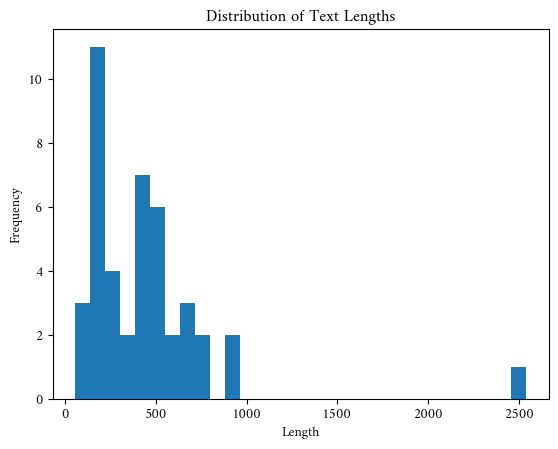

In [ ]:
# Histogram for texts length
import matplotlib.pyplot as plt


plt.hist(df['text_length'], bins=30)
plt.title('Distribution of Text Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

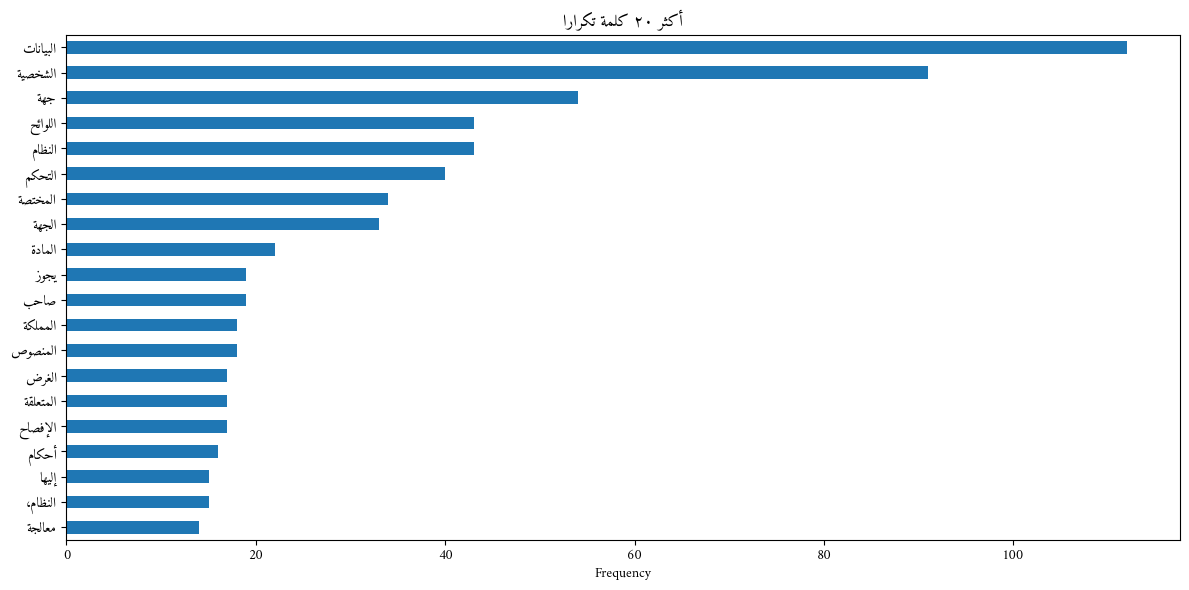

In [ ]:
# # Bar Plot for most repetitive words:

import re
import arabic_reshaper
from bidi.algorithm import get_display
import matplotlib.pyplot as plt

# 1) build the big text
text = " ".join(df['article_no_stop'].astype(str))

# 2) better tokenization for Arabic (avoid \w+)
tokens = re.findall(r"[\u0600-\u06FF]+", text)

# 3) top 20 frequencies
word_freq = pd.Series(tokens).value_counts().head(20)

# 4) reshape Arabic labels for plotting
labels = [
    get_display(arabic_reshaper.reshape(str(w)))
    for w in word_freq.sort_values().index
]

plt.figure(figsize=(12,6))
word_freq.sort_values().plot(kind='barh')  # خليه بدون title بالعربي الآن
plt.title(get_display(arabic_reshaper.reshape("أكثر ٢٠ كلمة تكرارًا")))
plt.xlabel('Frequency')

# 5) override y-ticks with reshaped Arabic labels
plt.yticks(range(len(labels)), labels)

plt.tight_layout()
plt.show()


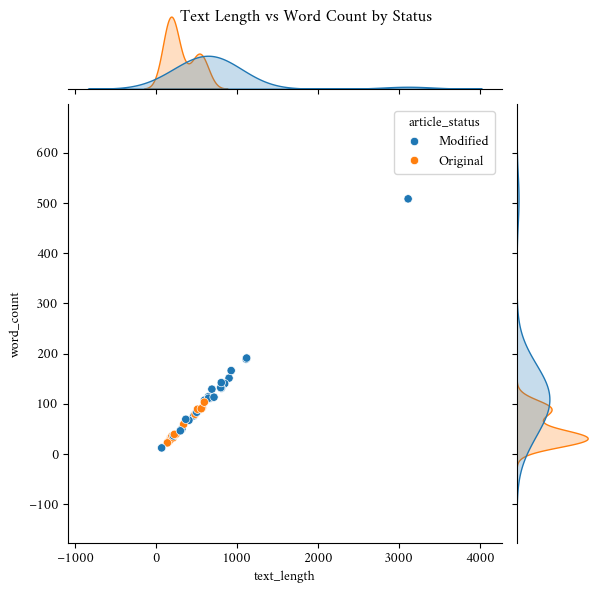

In [ ]:
import seaborn as sns

df['text_length'] = df['article_text'].apply(lambda x: len(str(x))) # add the column text len
df['word_count'] = df['article_text'].apply(lambda x: len(str(x).split()))

g = sns.jointplot(
    data=df,
    x='text_length',
    y='word_count',
    hue='article_status',
    kind='scatter'
)

g.fig.suptitle('Text Length vs Word Count by Status')
plt.show()


## 3. Correlation / Relationships analysis

In [ ]:
# this is for the model

import re
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
from itertools import combinations
from sklearn.feature_extraction.text import TfidfVectorizer
from IPython.display import display

# نتأكد أن الأعمدة المطلوبة موجودة
assert {'article_no_stop','article_status'}.issubset(df.columns), "Expected columns missing."
df = df.copy()

# Tokenizer
def tokenize_ar(text):
    return re.findall(r"\w+", str(text), flags=re.UNICODE)

# Length / word count بناءً على النص بعد إزالة كلمات الوقف
if 'text_length' not in df.columns:
    df['text_length'] = df['article_no_stop'].apply(lambda x: len(str(x)))
if 'word_count' not in df.columns:
    df['word_count'] = df['article_no_stop'].apply(lambda x: len(tokenize_ar(x)))

print("=== Length / Count by Status ===")
display(
    df.groupby('article_status')[['word_count','text_length']]
      .agg(['mean','median','min','max','std'])
      .round(2)
)

# Top words per status (على article_no_stop مباشرة)
print("\n=== Top Words per Status (stopwords removed already) ===")
for status in df['article_status'].unique():
    subset = df[df['article_status'] == status]
    toks = []
    for t in subset['article_no_stop']:
        toks.extend(tokenize_ar(t))
    toks = [w for w in toks if len(w) > 1]
    top = Counter(toks).most_common(15)
    top_df = pd.DataFrame(top, columns=['word','count'])
    print(f"\n[Status = {status}]")
    display(top_df)

# TF-IDF:
print("\n=== TF-IDF Distinctive Terms per Status ===")
vectorizer = TfidfVectorizer(
    max_features=2000,
    analyzer='word',
    token_pattern=r'\w+',
    lowercase=False
)

# 👇 هنا التحويل لنص عشان نتفادى TypeError
docs = df['article_no_stop'].fillna("").astype(str)
X = vectorizer.fit_transform(docs)
vocab = np.array(vectorizer.get_feature_names_out())

mask_mod = (df['article_status'] == 'Modified').to_numpy()
mask_org = (df['article_status'] == 'Original').to_numpy()
idx_mod = np.where(mask_mod)[0]
idx_org = np.where(mask_org)[0]

if idx_mod.size > 0:
    mean_mod = np.asarray(X[idx_mod].mean(axis=0)).ravel()
else:
    mean_mod = np.zeros(X.shape[1])

if idx_org.size > 0:
    mean_org = np.asarray(X[idx_org].mean(axis=0)).ravel()
else:
    mean_org = np.zeros(X.shape[1])

def top_terms(mean_vec, k=15):
    idx = mean_vec.argsort()[::-1][:k]
    return pd.DataFrame({'term': vocab[idx], 'score': mean_vec[idx]})

print("\nTop TF-IDF terms (Modified):")
display(top_terms(mean_mod, 15))

print("\nTop TF-IDF terms (Original):")
display(top_terms(mean_org, 15))

diff = mean_mod - mean_org
print("\nMost distinctive FOR Modified (score = mean_mod - mean_org):")
idx_mod_rel = diff.argsort()[::-1][:15]
display(pd.DataFrame({'term': vocab[idx_mod_rel], 'score': diff[idx_mod_rel]}))

print("\nMost distinctive FOR Original (score = mean_org - mean_mod):")
idx_org_rel = (-diff).argsort()[::-1][:15]
display(pd.DataFrame({'term': vocab[idx_org_rel], 'score': (-diff)[idx_org_rel]}))

# Co-occurrence
print("\n=== Co-occurrence (Top word pairs across articles) ===")
pair_counts = defaultdict(int)
for text in df['article_no_stop']:
    toks = [t for t in tokenize_ar(text) if len(t) > 1]
    if toks:
        # reduce noise
        local_freq = Counter(toks).most_common(50)
        keep = sorted({w for w, _ in local_freq})
        for a, b in combinations(keep, 2):
            pair_counts[(a, b)] += 1

top_pairs = sorted(pair_counts.items(), key=lambda x: x[1], reverse=True)[:15]
pairs_df = pd.DataFrame(
    [(a, b, c) for (a, b), c in top_pairs],
    columns=['word_a','word_b','co_docs']
)
display(pairs_df)

print("\nCorrelation-style analysis complete.")


=== Length / Count by Status ===


word_count                        text_length              \
                     mean median min  max    std        mean median  min   
article_status                                                             
Modified           123.46  112.0  12  508  94.08      733.17  658.0   70   
Original            50.89   35.0  22  103  28.92      306.11  210.0  141   

                              
                 max     std  
article_status                
Modified        3112  572.97  
Original         597  171.91


=== Top Words per Status (stopwords removed already) ===

[Status = Modified]


,word,count
0,البيانات,81
1,الشخصية,73
2,جهة,42
3,النظام,41
4,التحكم,38
5,اللوائح,31
6,الجهة,29
7,المختصة,29
8,المادة,20
9,جمعها,18



[Status = Original]


,word,count
0,البيانات,31
1,الشخصية,26
2,النظام,17
3,اللوائح,14
4,جهة,12
5,التحكم,10
6,معالجة,9
7,يجوز,8
8,المنصوص,7
9,المادة,7



=== TF-IDF Distinctive Terms per Status ===

Top TF-IDF terms (Modified):


,term,score
0,البيانات,0.099118
1,الشخصية,0.098049
2,جهة,0.068493
3,المختصة,0.067481
4,التحكم,0.066394
5,الجهة,0.065996
6,النظام,0.063059
7,جمعها,0.055024
8,اللوائح,0.046252
9,الغرض,0.046193



Top TF-IDF terms (Original):


,term,score
0,البيانات,0.095271
1,الشخصية,0.084443
2,النظام,0.062289
3,معالجة,0.054636
4,جهة,0.049030
5,اللوائح,0.047160
6,التحكم,0.043777
7,المنصوص,0.039412
8,جرى,0.038142
9,يجوز,0.038048



Most distinctive FOR Modified (score = mean_mod - mean_org):


,term,score
0,الجهة,0.044296
1,جمعها,0.043839
2,الغرض,0.041862
3,المختصة,0.039720
4,بياناته,0.038771
5,الإفصاح,0.035467
6,المعالجة,0.034882
7,الأحوال,0.031280
8,المعلومات,0.028342
9,الائتمانية,0.028006



Most distinctive FOR Original (score = mean_org - mean_mod):


,term,score
0,معالجة,0.041431
1,خدمة,0.025739
2,تصوير,0.024804
3,نسخها,0.024804
4,الضرر,0.023361
5,وتحدد,0.023171
6,المواد,0.022308
7,وسيلة,0.021985
8,المترتبة,0.021963
9,جرى,0.021958



=== Co-occurrence (Top word pairs across articles) ===


,word_a,word_b,co_docs
0,البيانات,الشخصية,33
1,البيانات,اللوائح,26
2,الشخصية,اللوائح,25
3,البيانات,النظام,23
4,البيانات,التحكم,22
5,البيانات,جهة,22
6,التحكم,الشخصية,22
7,الشخصية,جهة,22
8,الشخصية,النظام,21
9,اللوائح,النظام,21



Correlation-style analysis complete.


---

## EDA for secondary data

In this part, we perform Exploratory Data Analysis (EDA) on the **secondary dataset**,  
which contains external Q&A items related to the Saudi Personal Data Protection Law (PDPL).

We will cover:

1. Statistical Patterns  
2. Visualizations  
3. Text Correlations  
4. Metadata Review  
5. Bias Awareness


### 1. Statistical Patterns

In this step, we load the secondary dataset, clean the Arabic text by removing stopwords,  
and compute basic statistics such as text length and word counts for both questions and answers.  
These patterns help us understand how PDPL-related concepts are expressed in external written sources.


In [ ]:
import os
import pandas as pd
import re

# تحميل
df_sec = pd.read_csv("raw_data/pdpl_secondary_nonofficial.csv", encoding="utf-8-sig")

# لتجزئة الكلمات العربية
def tokenize_ar(text):
    return re.findall(r"[\u0600-\u06FF]+", str(text))

# نضمن إن الريبو موجود (نكلونه فقط إذا مو موجود)
if not os.path.isdir("Data-Science-Project"):
    !git clone https://github.com/Layantt/Data-Science-Project.git

# تحميل كلمات الوقف من الملف
STOPWORDS_PATH = "Data-Science-Project/data/arabic_stopwords.txt"
with open(STOPWORDS_PATH, encoding="utf-8") as f:
    AR_STOP = {w.strip() for w in f if w.strip()}

print("Loaded Arabic stopwords (file):", len(AR_STOP))

# ⬇️⬇️ إضافة مكتبة NLTK
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

nltk_ar = set(stopwords.words("arabic"))
print("Loaded NLTK Arabic stopwords:", len(nltk_ar))

# دمج القائمتين
AR_STOP = AR_STOP.union(nltk_ar)
print("Total merged stopwords:", len(AR_STOP))

# إنشاء نص من غير كلمات الوقف للسؤال
df_sec["question_no_stop"] = df_sec["question"].apply(
    lambda t: " ".join([w for w in tokenize_ar(t) if w not in AR_STOP])
)

# إنشاء نص من غير كلمات الوقف للإجابة
df_sec["answer_no_stop"] = df_sec["answer"].apply(
    lambda t: " ".join([w for w in tokenize_ar(t) if w not in AR_STOP])
)

# حساب طول النص (عدد الأحرف) للأسئلة والإجابات
df_sec["q_length"] = df_sec["question_no_stop"].str.len()
df_sec["a_length"] = df_sec["answer_no_stop"].str.len()

# حساب عدد الكلمات في الأسئلة والإجابات
df_sec["q_word_count"] = df_sec["question_no_stop"].apply(lambda x: len(str(x).split()))
df_sec["a_word_count"] = df_sec["answer_no_stop"].apply(lambda x: len(str(x).split()))

df_sec[["q_length","a_length","q_word_count","a_word_count"]].describe()


Loaded Arabic stopwords (file): 799
Loaded NLTK Arabic stopwords: 701
Total merged stopwords: 894


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,q_length,a_length,q_word_count,a_word_count
count,17.000000,17.000000,17.000000,17.000000
mean,44.235294,73.000000,6.529412,10.705882
std,9.045229,21.693893,1.280510,2.733238
min,29.000000,43.000000,4.000000,7.000000
25%,39.000000,54.000000,6.000000,9.000000
50%,42.000000,75.000000,6.000000,11.000000
75%,51.000000,80.000000,7.000000,11.000000
max,62.000000,129.000000,9.000000,18.000000


### 2. Visualizations

In this step, we visualize the distribution of question and answer lengths,  
and the most frequent words appearing in the secondary dataset.  
These plots give an intuitive understanding of how dense and repetitive the text is.


### 📊 A — Distribution of Question Lengths  
In this step, we visualize the distribution of the textual lengths of the questions in the secondary dataset.  
This plot helps identify whether the questions are short, medium, or long, and whether there are outliers affecting the overall distribution.


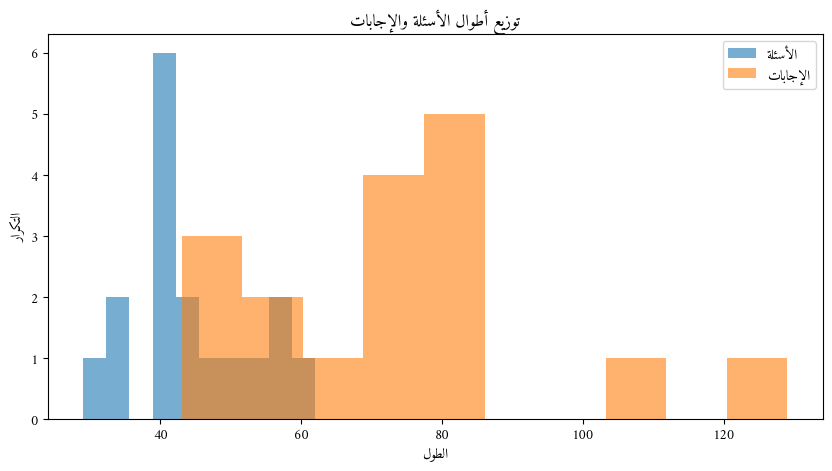

In [ ]:
plt.figure(figsize=(10,5))
plt.hist(df_sec["q_length"], bins=10, alpha=0.6, label=get_display(arabic_reshaper.reshape("الأسئلة")))
plt.hist(df_sec["a_length"], bins=10, alpha=0.6, label=get_display(arabic_reshaper.reshape("الإجابات")))
plt.title(get_display(arabic_reshaper.reshape("توزيع أطوال الأسئلة والإجابات")))
plt.xlabel(get_display(arabic_reshaper.reshape("الطول")))
plt.ylabel(get_display(arabic_reshaper.reshape("التكرار")))
plt.legend()
plt.show()


### 📊 B — Distribution of Answer Lengths  
This histogram visualizes the distribution of answer lengths after cleaning and preprocessing.  
It provides insight into how detailed or concise the answers are, and highlights variations across the dataset.



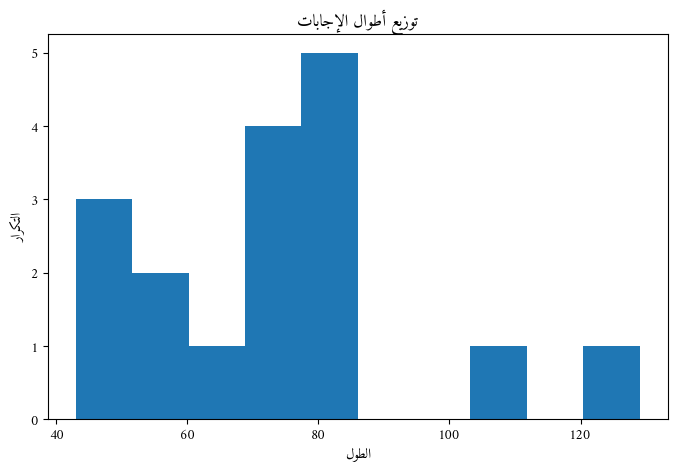

In [ ]:
plt.figure(figsize=(8,5))
plt.hist(df_sec["a_length"], bins=10)
plt.title(get_display(arabic_reshaper.reshape("توزيع أطوال الإجابات")))
plt.xlabel(get_display(arabic_reshaper.reshape("الطول")))
plt.ylabel(get_display(arabic_reshaper.reshape("التكرار")))
plt.show()


### 📊 C — Top 20 Most Frequent Words (Questions + Answers)  
In this section, we generate a combined word-frequency bar chart for both questions and answers.  
After removing Arabic stopwords, we highlight the 20 most repeated informative words across the secondary dataset.  
This helps reveal the dominant concepts and themes within the collected text.


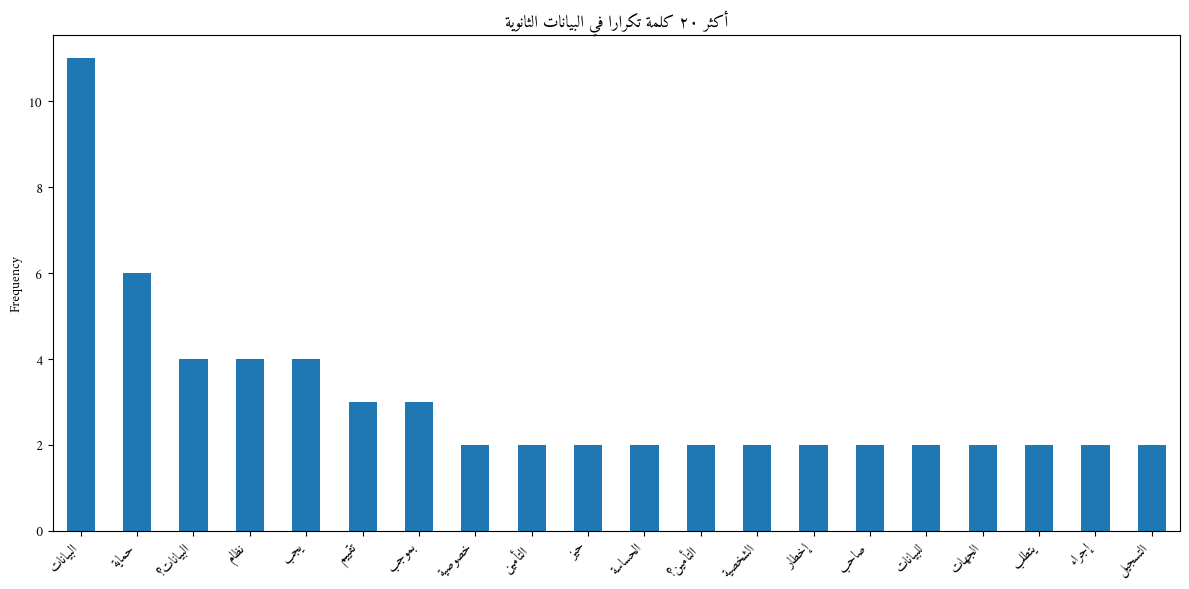

In [ ]:
from collections import Counter

# دمج نصوص الأسئلة والإجابات بعد إزالة كلمات الوقف
all_text = " ".join(df_sec["question_no_stop"]) + " " + " ".join(df_sec["answer_no_stop"])

# استخراج الكلمات العربية
tokens = re.findall(r"[\u0600-\u06FF]+", all_text)
# فلترة الكلمات القصيرة جداً
tokens = [w for w in tokens if len(w) > 2]

freq = pd.Series(Counter(tokens)).sort_values(ascending=False).head(20)

# إعادة تشكيل النص العربي ليظهر بطريقة صحيحة في الرسم
labels = [get_display(arabic_reshaper.reshape(str(w))) for w in freq.index]

plt.figure(figsize=(12,6))
ax = freq.plot(kind="bar")
ax.set_xticklabels(labels, rotation=45, ha="right")
plt.title(get_display(arabic_reshaper.reshape("أكثر ٢٠ كلمة تكرارًا في البيانات الثانوية")))
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


### 📊 D — Boxplot Comparison of Question vs. Answer Lengths  
This boxplot provides a side-by-side comparison of the lengths of questions and answers.  
It helps identify differences in text distribution, median length, variability, and potential outliers between the two types of text.


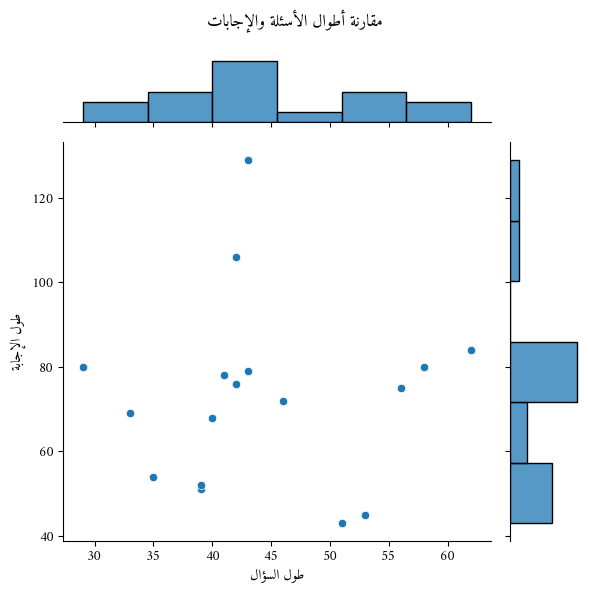

In [ ]:
import seaborn as sns

g = sns.jointplot(
    data=df_sec,
    x="q_length",
    y="a_length",
    kind="scatter"
)

g.fig.suptitle(
    get_display(arabic_reshaper.reshape("مقارنة أطوال الأسئلة والإجابات"))
)

g.set_axis_labels(
    get_display(arabic_reshaper.reshape("طول السؤال")),
    get_display(arabic_reshaper.reshape("طول الإجابة"))
)

g.fig.tight_layout()
g.fig.subplots_adjust(top=0.9)


### 3. Text Correlations

Here we examine simple relationships between questions and answers,  
such as how the length of a question relates to the length of its corresponding answer.  
This gives an indication of how detailed the answers are compared to the questions.


In [ ]:
# حساب معامل الارتباط بين طول وعدد كلمات السؤال والإجابة
corr = df_sec[["q_word_count","a_word_count","q_length","a_length"]].corr()
corr


,q_word_count,a_word_count,q_length,a_length
q_word_count,1.000000,0.082985,0.830360,0.078746
a_word_count,0.082985,1.000000,-0.002082,0.952870
q_length,0.830360,-0.002082,1.000000,0.016563
a_length,0.078746,0.952870,0.016563,1.000000


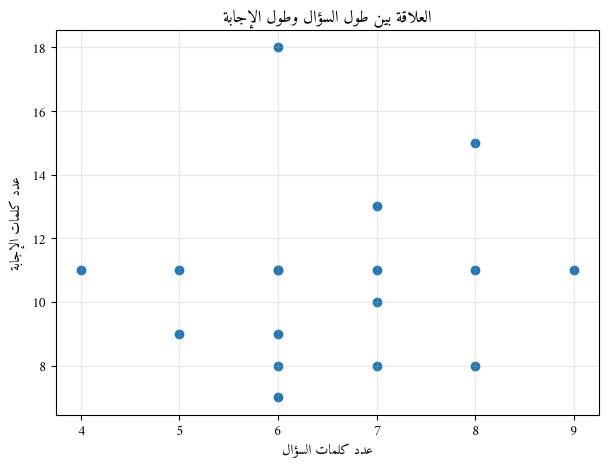

In [ ]:
plt.figure(figsize=(7,5))
plt.scatter(df_sec["q_word_count"], df_sec["a_word_count"])
plt.xlabel(get_display(arabic_reshaper.reshape("عدد كلمات السؤال")))
plt.ylabel(get_display(arabic_reshaper.reshape("عدد كلمات الإجابة")))
plt.title(get_display(arabic_reshaper.reshape("العلاقة بين طول السؤال وطول الإجابة")))
plt.grid(True, alpha=0.3)
plt.show()


## 4. Metadata Review

 #### The dataset used in this project was collected from the official Saudi Laws Portal managed by the Bureau of Experts at the Council of Ministers, which serves as the authoritative source of Saudi legal texts.

     Source: Saudi Laws Portal (https://laws.boe.gov.sa/boelaws/laws/lawdetails/b7cfae89-828e-4994-b167-adaa00e37188/1)

- Date Collected: September 2025

- Collection Method: Web scraping using Python libraries (requests, BeautifulSoup) to extract legal articles from the PDPL page. A raw HTML snapshot was stored for reproducibility.

- Language: Arabic

- Number of Records: 43 legal articles (19 original and 24 modified).

- Data Format: CSV (pdpl_articles_enhanced.csv and pdpl_cleaned.csv)

- Descriptive Statistics:

  - Average word count: ~91 words per article (min = 12, max = 508)

  - Average character length: ~544 characters (min = 70, max = 3112)

  - Most frequent words: “البيانات”، “الشخصية”، “جهة”، “التحكم”، “الجهة المختصة”

    *These statistics reveal a high variance in article length and linguistic concentration around specific legal terms, which reflects the formal language and structure of the PDPL. Such characteristics must be considered during analysis to avoid skewed interpretations.*

- Features:

  - article_title: Official title of each article.

  - article_text: Full legal text of each article.

  - article_status: Indicates whether the article is original, modified, or unknown.

  - modification_text: Amendment details if available.

  - category (added manually): Label assigned by the research team to classify articles thematically.

  - text_length: Number of characters in each article text.

  - word_count: Number of words in each article text.

**The secondary data:**

**Dataset description:**  
This secondary dataset consists of a manually curated set of questions and answers (Q&A) about the Personal Data Protection Law (PDPL). It is intended for educational use to support exploratory analysis and downstream experiments.

**Source:**  
Consolidated from non-official educational materials (practice/exam-style Q&A aligned with PDPL concepts). The legal grounding is the official PDPL, but the phrasing of items is not taken verbatim from the Saudi Laws Portal.

**Date collected:**  
October 2025 (update if needed).

**Collection method:**  
Manual curation and light text cleaning using Python (regex + pandas). A CSV export was produced for reproducibility.

**Language & encoding:**  
Arabic (UTF-8 / UTF-8-SIG for CSV).

**Size:**  
30 observations (rows) × 3 features (columns).

**Schema and data types:**  
- `id` (integer): row identifier  
- `question` (string): the PDPL-related question (in Arabic)  
- `answer` (string): a concise Arabic answer consistent with PDPL concepts  

**Derived features (added during EDA):**  
- `q_len` (integer): character length of the question  
- `a_len` (integer): character length of the answer  

**File & format:**  
`raw_data/pdpl_secondary_nonofficial.csv` (CSV, UTF-8-SIG).

**Intended use:**  
Exploratory Data Analysis (EDA) to study distribution of text lengths, compare question vs answer verbosity, inspect outliers, and document potential sources of bias.

**Notes:**  
While items are conceptually aligned with the PDPL, this dataset is not an official transcription; wording reflects educational curation rather than statutory text.

## 5. Bias Analysis


*The Primery dataset consists of 43 legal articles collected from the Saudi Laws Portal, with 24 modified articles and 19 original articles. Although the source is official and reliable, several biases can affect the interpretation of analytical results:*

1. **Source Bias**

All data originates from a single official governmental source, which reflects the formal legal language used by the state. This means it does not represent interpretations from other stakeholders such as legal practitioners, private institutions, or the public.

2. **Linguistic Bias**
The word frequency analysis showed heavy repetition of specific legal terms, such as:

“البيانات” (112 occurrences)

“الشخصية” (82 occurrences)

“جهة” (53 occurrences)

“التحكم” (37 occurrences)

“الجهة المختصة” (31 occurrences)
This repetition may dominate WordClouds and frequency plots, making other contextual words appear less significant — a common limitation in legal corpora.

3. **Distribution Bias**
The word count distribution is uneven:

Mean = 91 words

Min = 12 words (shortest article)

Max = 508 words (longest article)
Some articles are significantly longer than others (e.g., Article 1) and could skew average values or influence models trained on this data if not normalized properly.

4. **Temporal Bias**
The dataset reflects the PDPL as of September 2025. Since the law is subject to amendments, these findings might become outdated with future legal changes. This can affect the long-term validity of any derived insights.

5. **Collection Method Bias**
The dataset was collected via web scraping. Although validated, the extraction process depends on the structure of the web page (DOM). If this structure changes or if some content (e.g., popups) was missed, it could result in incomplete data.

## Bias Analysis — Secondary Data

**Representation bias:**  
Because the Q&A items were manually curated, certain topics (e.g., consent, rights, controller/processor duties) may be over-represented compared to others (e.g., exceptions, international transfers). The set is small (30 items), which further limits coverage.

**Measurement / collection bias:**  
Variation in phrasing style and detail across questions and answers affects measured lengths (`q_len`, `a_len`) and frequency patterns. Selection bias is possible (authors’ preferences, examples seen in courses). Cleaning rules can also influence tokenization and counts.

**Historical / temporal bias:**  
Answers may reflect interpretations at the time of curation and might not capture later amendments or guidance. Without explicit versioning of the law for each Q&A item, temporal drift can occur.

**Source / authority bias:**  
Although conceptually grounded in the official PDPL, the dataset is non-official; it does not incorporate judicial interpretations or regulatory decisions, which can shape real-world application.

**Linguistic / structural bias:**  
Legal Arabic reuses formal terms (e.g., بيانات ، شخصية ، معالجة ، جهة ، متحكم) that dominate frequency analyses and overshadow contextual words.

**Sampling bias:**  
A sample of 30 items is insufficient to generalize patterns across all PDPL topics. The dataset should be treated as illustrative rather than exhaustive.

**Mitigations (recommended):**  
Track PDPL version and date in metadata, expand topic coverage with balanced sampling, document curation criteria, retain original punctuation where informative, and periodically re-validate items against updated legal texts.


# Compare Key Metrics

| Aspect                        | Primary Data (Legal Articles)                | Secondary Data (Q&A Explanations)             |
|-------------------------------|----------------------------------------------|-----------------------------------------------|
| **Type of Content**           | Official legal articles                      | Simplified Q&A explanations                   |
| **Language Style**           | Formal, legal, precise                       | Informal, clear, accessible                   |
| **Purpose**                   | Define and enforce the law                   | Explain and interpret the law                 |
| **Audience**                  | Legal experts and authorities                | General public and learners                   |
| **Format**                    | Long legal paragraphs                        | Short questions and answers                   |
| **Count**                     | 43                                           | 17                                            |
| **Mean**                      | 64.953488 words                                  | Q: 6.529412 words — A: 10.7words              |
| **Std (Standard Deviation)**  | 57.035475                                        | Q: 1.28051 — A: 2.733238                            |
| **Min**                       | 8                                           | Q: 4 — A: 7                                |                                                   
| **Max**                       | 362                                          | Q: 9 — A: 18                                 |


 Both datasets are related to the Personal Data Protection Law (PDPL) but serve different purposes
The primary dataset contains the official legal text, while the secondary dataset provides simplified explanations to help the public understand the same concepts.
They complement each other, the primary dataset defines the law, and the secondary one interprets it.

**Summary:**

The primary data presents official and binding legal content, while the secondary data explains it in a simplified way.

There are no contradictions between them — the differences mainly reflect language, purpose, and target audience.



# Modelling and Communication


In this phase, we focused on applying Natural Language Processing (NLP) models to analyze the full text of the Personal Data Protection Law (PDPL). Since the dataset consists entirely of unlabelled legal articles, the modelling approach follows an unsupervised learning framework. The goal of the modelling stage is not prediction, but understanding — specifically, to identify patterns, discover hidden topics, and measure relationships between articles at both the lexical and semantic levels. Three models were developed to achieve this: TF-IDF Similarity, LDA Topic Modeling, and Sentence Embeddings Similarity. Each model serves a different analytical purpose, providing a complementary perspective on the structure and content of the law.

In [ ]:
"""
Model 1: TF-IDF Similarity Analysis
====================================
Calculate similarity between PDPL (Personal Data Protection Law) articles
using TF-IDF and Cosine Similarity
"""

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# 1. LOAD DATA
# ============================================================================

def load_data(file_path):
    """Load the dataset"""
    print("Loading data...")
    df = pd.read_csv(file_path)

    print(f"Loaded {len(df)} articles")
    print(f"Available columns: {df.columns.tolist()}\n")

    return df


# ============================================================================
# 2. PREPARE TEXT DATA
# ============================================================================

def prepare_texts(df):
    """Combine article title and text together"""
    print("Preparing texts...")
    texts = (
        df["article_title"].fillna("") + " " +
        df["article_text"].fillna("")
    ).tolist()

    print(f"Prepared {len(texts)} texts\n")
    return texts


# ============================================================================
# 3. CREATE TF-IDF VECTORS
# ============================================================================

def create_tfidf_matrix(texts):
    """Create TF-IDF matrix"""
    print("Computing TF-IDF...")

    vectorizer = TfidfVectorizer(
        max_df=0.85,        # Ignore very common words (>85%)
        min_df=2,           # Word must appear at least twice
        ngram_range=(1, 2), # Use unigrams + bigrams
        max_features=5000   # Maximum number of features
    )

    tfidf_matrix = vectorizer.fit_transform(texts)

    print(f"TF-IDF Matrix: {tfidf_matrix.shape[0]} articles × {tfidf_matrix.shape[1]} features")
    print(f"Number of features used: {len(vectorizer.get_feature_names_out())}\n")

    return tfidf_matrix, vectorizer


# ============================================================================
# 4. COMPUTE SIMILARITY
# ============================================================================

def compute_similarity(tfidf_matrix, article_titles):
    """Calculate similarity between articles"""
    print("Computing similarity...")

    similarity_matrix = cosine_similarity(tfidf_matrix)

    # Convert to DataFrame for easier reading
    sim_df = pd.DataFrame(
        similarity_matrix,
        index=article_titles,
        columns=article_titles
    )

    print(f"Computed {similarity_matrix.shape[0]}×{similarity_matrix.shape[1]} similarities\n")

    return sim_df


# ============================================================================
# 5. EXTRACT TOP SIMILAR ARTICLES
# ============================================================================

def extract_top_similar(sim_df, top_n=3):
    """Extract top N most similar articles for each article"""
    print(f"Extracting top {top_n} most similar articles for each article...")

    results = []

    for title in sim_df.index:
        # Get similarity scores for current article
        sims = sim_df.loc[title].copy()

        # Exclude the article itself
        sims = sims.drop(labels=[title])

        # Get top N articles
        top_sim = sims.sort_values(ascending=False).head(top_n)

        for other_title, score in top_sim.items():
            results.append({
                "article_title": title,
                "similar_article_title": other_title,
                "similarity_score": round(score, 4)
            })

    similar_pairs = pd.DataFrame(results)

    print(f"Extracted {len(similar_pairs)} similar article pairs\n")

    return similar_pairs


# ============================================================================
# 6. DISPLAY SUMMARY STATISTICS
# ============================================================================

def display_summary(similar_pairs):
    """Display summary statistics"""
    print("=" * 60)
    print("RESULTS SUMMARY")
    print("=" * 60)

    print(f"\nSimilarity Score Statistics:")
    print(similar_pairs["similarity_score"].describe())

    print(f"\nTop 5 Most Similar Pairs:")
    top_5 = similar_pairs.nlargest(5, "similarity_score")
    for idx, row in top_5.iterrows():
        print(f"   • {row['article_title'][:40]}... <-> {row['similar_article_title'][:40]}... ({row['similarity_score']:.3f})")

    print("\n" + "=" * 60 + "\n")


# ============================================================================
# 7. SAVE RESULTS
# ============================================================================

def save_results(similar_pairs, output_file):
    """Save results to CSV file"""
    similar_pairs.to_csv(output_file, index=False, encoding='utf-8-sig')
    print(f"Results saved to: {output_file}")


# ============================================================================
# MAIN EXECUTION
# ============================================================================

def main():
    """Main function"""

    print("\n" + "=" * 60)
    print("Model 1: TF-IDF Similarity Analysis")
    print("=" * 60 + "\n")

    # 1. Load data
    df = load_data("raw_data/pdpl_cleaned.csv")   # 👈 التعديل هنا

    # 2. Prepare texts
    texts = prepare_texts(df)

    # 3. Create TF-IDF matrix
    tfidf_matrix, vectorizer = create_tfidf_matrix(texts)

    # 4. Compute similarity
    sim_df = compute_similarity(tfidf_matrix, df["article_title"])

    # 5. Extract top similar articles
    similar_pairs = extract_top_similar(sim_df, top_n=3)

    # 6. Display summary
    display_summary(similar_pairs)

    # 7. Save results
    save_results(similar_pairs, "model1_tfidf_similarity_results.csv")

    print("Analysis completed successfully!\n")

    return similar_pairs, sim_df, vectorizer



# ============================================================================
# RUN
# ============================================================================

if __name__ == "__main__":
    similar_pairs, sim_df, vectorizer = main()


Model 1: TF-IDF Similarity Analysis

Loading data...
Loaded 43 articles
Available columns: ['article_title', 'article_text', 'article_status', 'modification_text']

Preparing texts...
Prepared 43 texts

Computing TF-IDF...
TF-IDF Matrix: 43 articles × 834 features
Number of features used: 834

Computing similarity...
Computed 43×43 similarities

Extracting top 3 most similar articles for each article...
Extracted 129 similar article pairs

RESULTS SUMMARY

Similarity Score Statistics:
count    129.000000
mean       0.314082
std        0.099378
min        0.089700
25%        0.230700
50%        0.302800
75%        0.397300
max        0.644900
Name: similarity_score, dtype: float64

Top 5 Most Similar Pairs:
   • المادة العاشرة... <-> المادة الخامسة عشرة... (0.645)
   • المادة الخامسة عشرة... <-> المادة العاشرة... (0.645)
   • المادة الخامسة والثلاثون... <-> المادة السادسة والثلاثون... (0.538)
   • المادة السادسة والثلاثون... <-> المادة الخامسة والثلاثون... (0.538)
   • المادة الرابعة..

**Article Similarity Matrix (TF-IDF Heatmap)**

In this section, we generate a heatmap to visualize the TF-IDF similarity between all PDPL articles. The heatmap provides an intuitive overview of which articles are closely related in terms of wording and content, and which ones differ significantly. This visual representation helps identify natural clusters within the law and makes the similarity patterns easier to interpret.

Current matplotlib font family: ['Amiri']
📂 Loading data...
✅ Saved: heatmap.png


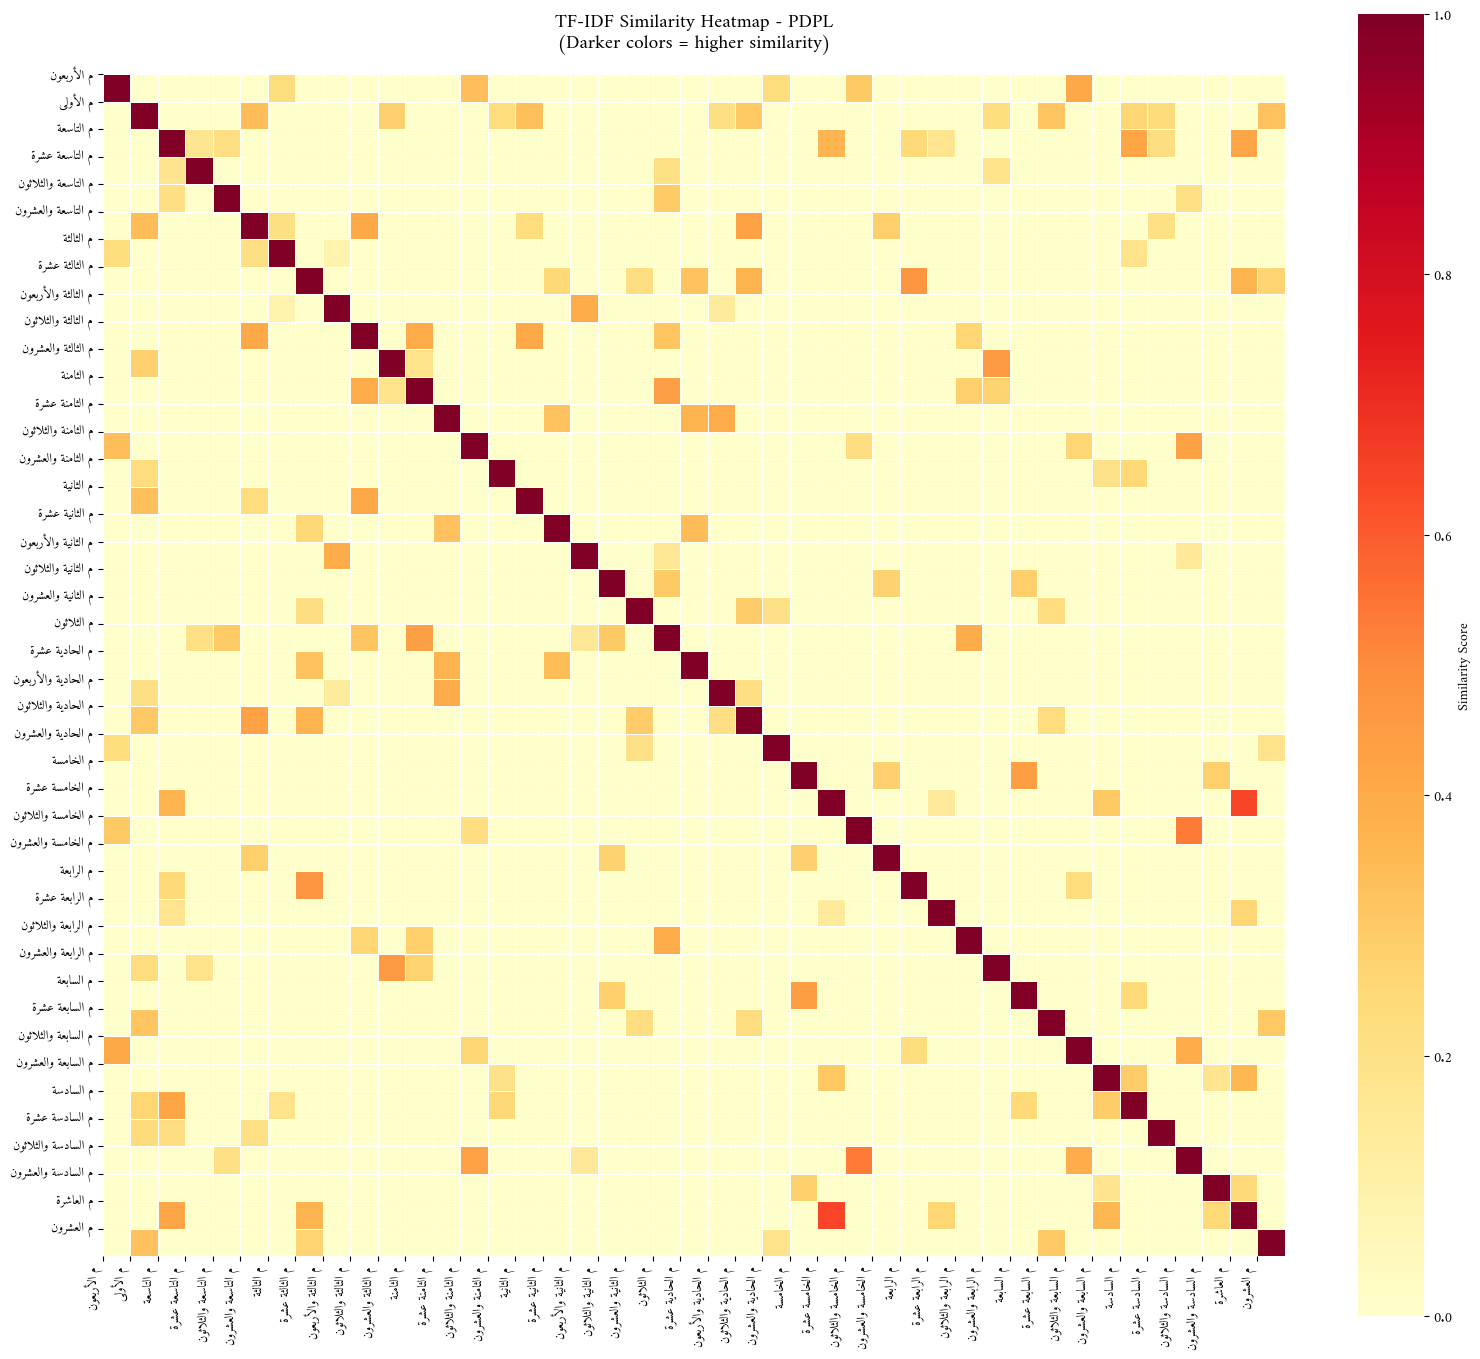

In [ ]:
"""
Heatmap of TF-IDF Similarity between PDPL Articles
===================================================
This script visualizes the similarity scores between all PDPL articles
using a heatmap representation.
"""

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# إعداد الخط العربي (نفس أسلوب الـ EDA)
# نتأكد أن الريبو موجود
if not os.path.isdir("Data-Science-Project"):
    !git clone https://github.com/Layantt/Data-Science-Project.git

# مكتبات عرض العربي
%pip install arabic-reshaper python-bidi -q

from matplotlib import font_manager, rcParams
import arabic_reshaper
from bidi.algorithm import get_display

# إضافة الخط من مجلد المشروع
FONT_PATH = "Data-Science-Project/fonts/Amiri-Regular.ttf"
font_manager.fontManager.addfont(FONT_PATH)
rcParams['font.family'] = 'Amiri'

print("Current matplotlib font family:", rcParams['font.family'])

# Load data
print("📂 Loading data...")
df = pd.read_csv("model1_tfidf_similarity_results.csv")

# Create similarity matrix
articles = sorted(df['article_title'].unique())
n = len(articles)
similarity_matrix = np.zeros((n, n))

# Fill matrix with similarity scores
for _, row in df.iterrows():
    i = articles.index(row['article_title'])
    j = articles.index(row['similar_article_title'])
    similarity_matrix[i, j] = row['similarity_score']
    similarity_matrix[j, i] = row['similarity_score']

# Set diagonal to 1.0 (article compared with itself)
np.fill_diagonal(similarity_matrix, 1.0)

# Plot heatmap
plt.figure(figsize=(16, 14))

sns.heatmap(
    similarity_matrix,
    cmap='YlOrRd',           # Yellow → Orange → Red gradient
    annot=False,             # No numbers inside the cells
    cbar_kws={'label': 'Similarity Score'},
    linewidths=0.5,
    linecolor='white',
    square=True,
    vmin=0,
    vmax=1
)

# Shorten article labels + تهيئة عربية
raw_labels = [a.replace('المادة ', 'م ') for a in articles]
labels = [get_display(arabic_reshaper.reshape(lbl)) for lbl in raw_labels]

plt.xticks(range(n), labels, rotation=90, ha='right', fontsize=9)
plt.yticks(range(n), labels, rotation=0, fontsize=9)

plt.title('TF-IDF Similarity Heatmap - PDPL\n(Darker colors = higher similarity)',
          fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('heatmap.png', dpi=200, bbox_inches='tight')
print("✅ Saved: heatmap.png")
plt.show()


# Zero-Shot Prompting

In [ ]:
!pip install -q -U google-genai

In [ ]:
import google.generativeai as genai
import os
from typing import List, Dict
import json
from dotenv import load_dotenv

In [ ]:
api_key = ""  #حطي الكي لحسابك هنا
import os
os.environ["GEMINI_API_KEY"] = api_key

In [ ]:
from google import genai

# The client gets the API key from the environment variable `GEMINI_API_KEY`.
client = genai.Client()

In [ ]:
# prompt = f"""Given the following article, generate {num_questions} question-answer pairs that cover the main points of the article.

# Article:
# {article}

# Please format your response as a JSON array with objects containing 'question' and 'answer' fields.
# """

In [ ]:
#read from csv file
import pandas as pd
df = pd.read_csv("raw_data/pdpl_cleaned.csv")
df


,article_title,article_text,article_status,modification_text
0,المادة الأولى,لغرض تطبيق هذا النظام، يُقصد بالألفاظ والعبارا...,Modified,صدر المرسوم الملكي رقم م وتاريخ هـ، وذلك بتعدي...
1,المادة الثانية,يُطبق النظام على أي عملية مُعالجة لبيانات شخصي...,Original,لا يوجد نص معدل
2,المادة الثالثة,لا تخل الأحكام والإجراءات المنصوص عليها في الن...,Original,لا يوجد نص معدل
3,المادة الرابعة,يكون لصاحب البيانات الشخصية وفقاً للأحكام الوا...,Modified,عُدلت هذه المادة وذلك بموجب المرسوم الملكي رقم...
4,المادة الخامسة,فيما عدا الأحوال المنصوص عليها في النظام، لا ت...,Modified,إحلال كلمة صريحة محل كلمة كتابية الواردة في ال...
5,المادة السادسة,لا تخضع معالجة البيانات الشخصية للموافقة المشا...,Modified,إضافة فقرة إلى هذه المادة، وذلك بموجب المرسوم...
6,المادة السابعة,لا يجوز أن تكون الموافقة المشار إليها في الفقر...,Original,لا يوجد نص معدل
7,المادة الثامنة,مع مراعاة ما ينص عليه النظام واللوائح في شأن ا...,Modified,عُدلت هذه المادة وذلك بموجب المرسوم الملكي رقم...
8,المادة التاسعة,يجوز لجهة التحكم تحديد مدد لممارسة حق الوصول إ...,Modified,عُدلت الفقرة من هذه المادة وذلك بموجب المرسوم...
9,المادة العاشرة,لا يجوز لجهة التحكم جمع البيانات الشخصية إلاَّ...,Modified,عُدلت هذه المادة وذلك بموجب المرسوم الملكي رقم...


In [ ]:
results = []
count = 0  # عشان نطبع فقط أول 3

for idx, row in df.iterrows():

    original = str(row["article_text"]).strip()
    status = row["article_status"].strip()

    if status == "Modified":
        modified = str(row["modification_text"]).strip()
        versions = [
            ("original", original),
            ("modified", modified)
        ]
    else:
        versions = [
            ("original", original)
        ]

    for version_type, article in versions:

        prompt = f"""Given the following article, generate question-answer pair that cover the main points of the article.

Article:
{article}

Please format your response as a JSON array with objects containing 'question' and 'answer' fields.
"""

        response = client.models.generate_content(
            model="gemini-2.5-flash", contents=prompt
        )

        # حفظ النتيجة في list
        results.append({
            "article": article,
            "version": version_type,
            "qa_output": response.text
        })

        # طباعة أول 3 فقط
        if count < 3:
            print("Version:", version_type)
            print(response.text)
            print("\n")
            count += 1


# حفظ كل النتائج في ملف JSON
with open("qa_results.json", "w", encoding="utf-8") as f:
    json.dump(results, f, ensure_ascii=False, indent=2)

print("All results saved to qa_results.json")


```json
[
  {
    "question": "ما هو المقصود بمصطلح 'النظام' في سياق هذا النص؟",
    "answer": "يُقصد بمصطلح 'النظام' في هذا السياق 'نظام حماية البيانات الشخصية'."
  },
  {
    "question": "ما الذي تعنيه 'اللوائح' وفقاً لهذا النظام؟",
    "answer": "تعني 'اللوائح' في هذا النظام 'اللوائح التنفيذية للنظام'."
  },
  {
    "question": "كيف يتم تحديد 'الجهة المختصة' في سياق هذا النظام؟",
    "answer": "تُحدد 'الجهة المختصة' بقرار من مجلس الوزراء."
  },
  {
    "question": "ما هي 'البيانات الشخصية' وما أمثلتها؟",
    "answer": "البيانات الشخصية هي كل بيان مهما كان مصدره أو شكله من شأنه أن يؤدي إلى معرفة الفرد على وجه التحديد، أو يجعل التعرف عليه ممكنًا بصفة مباشرة أو غير مباشرة. ومن أمثلتها: الاسم، ورقم الهوية الشخصية، والعناوين، وأرقام التواصل، وأرقام الرخص والسجلات والممتلكات الشخصية، وأرقام الحسابات البنكية والبطاقات الائتمانية، وصور الفرد الثابتة أو المتحركة، وغير ذلك من البيانات ذات الطابع الشخصي."
  },
  {
    "question": "ما المقصود بعملية 'المُعالجة' للبيانات الشخصية؟",
    "answer":

ClientError: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. \n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 250, model: gemini-2.5-flash\nPlease retry in 11.124426812s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerDayPerProjectPerModel-FreeTier', 'quotaDimensions': {'location': 'global', 'model': 'gemini-2.5-flash'}, 'quotaValue': '250'}]}, {'@type': 'type.googleapis.com/google.rpc.RetryInfo', 'retryDelay': '11s'}]}}

# One-Shot Prompting

In [ ]:
from google.genai.errors import ClientError
import json

one_shot_results = []
count = 0  # لطباعة أول 3 فقط

for idx, row in df.iterrows():

    original = str(row["article_text"]).strip()
    status = row["article_status"].strip()


    if status == "Modified":
        modified = str(row["modification_text"]).strip()
        versions = [
            ("original", original),
            ("modified", modified)
        ]
    else:
        versions = [
            ("original", original)
        ]


    for version_type, article in versions:

        prompt = f"""
Example:
Article:
"البيانات الشخصية هي أي معلومات عن فرد يمكن التعرف عليه بشكل مباشر أو غير مباشر."

Output (JSON):
[
  {{
    "question": "ما المقصود بالبيانات الشخصية؟",
    "answer": "هي أي معلومات عن فرد يمكن التعرف عليه بشكل مباشر أو غير مباشر."
  }}
]

Given the following article, generate question-answer pair that cover the main points of the article.

Article:
{article}

Please format your response as a JSON array with objects containing 'question' and 'answer' fields.
"""

        response = client.models.generate_content(
            model="gemini-2.5-flash",
            contents=prompt
        )

        one_shot_results.append({
            "article": article,
            "version": version_type,  # original OR modified
            "qa_output": response.text
        })

        # طباعة أول 3 فقط
        if count < 3:
            print("===== One-shot sample #", count + 1, "=====")
            print("Version:", version_type)
            print(response.text)
            print("\n")
            count += 1


# حفظ جميع النتائج
with open("qa_results_oneshot.json", "w", encoding="utf-8") as f:
    json.dump(one_shot_results, f, ensure_ascii=False, indent=2)

print("All one-shot results saved to qa_results_oneshot.json")


# Few-Shot Prompting

In [ ]:
few_shot_results = []
count = 0  # لطباعة أول 3 فقط

for idx, row in df.iterrows():

    original = str(row["article_text"]).strip()
    status = row["article_status"].strip()

    if status == "Modified":
        modified = str(row["modification_text"]).strip()
        versions = [
            ("original", original),
            ("modified", modified)
        ]
    else:
        versions = [
            ("original", original)
        ]

    for version_type, article in versions:

        prompt = f"""
Example 1:
Article:
"البيانات الشخصية هي أي معلومات عن فرد يمكن التعرف عليه بشكل مباشر أو غير مباشر."

Output (JSON):
[
  {{
    "question": "ما المقصود بالبيانات الشخصية؟",
    "answer": "هي أي معلومات عن فرد يمكن التعرف عليه بشكل مباشر أو غير مباشر."
  }}
]

Example 2:
Article:
"لا يجوز جمع البيانات الشخصية أو معالجتها إلا لأغراض مشروعة وواضحة، وبالقدر اللازم لتحقيق تلك الأغراض."

Output (JSON):
[
  {{
    "question": "ما الشرط لمعالجة البيانات الشخصية؟",
    "answer": "أن تكون المعالجة لأغراض مشروعة وواضحة وبالقدر اللازم لتحقيق تلك الأغراض."
  }}
]

Given the following article, generate question-answer pair that cover the main points of the article.

Article:
{article}

Please format your response as a JSON array with objects containing 'question' and 'answer' fields.
"""

        response = client.models.generate_content(
            model="gemini-2.5-flash",
            contents=prompt
        )

        # تخزين النتيجة
        few_shot_results.append({
            "article": article,
            "version": version_type,   # original أو modified
            "qa_output": response.text
        })

        # طباعة أول 3 فقط للتوضيح
        if count < 3:
            print("===== Few-shot sample #", count + 1, "=====")
            print("Version:", version_type)
            print(response.text)
            print("\n")
            count += 1

# حفظ كل النتائج في ملف JSON مستقل
with open("qa_results_fewshot.json", "w", encoding="utf-8") as f:
    json.dump(few_shot_results, f, ensure_ascii=False, indent=2)

print("All few-shot results saved to qa_results_fewshot.json")

------------------------------------------------

In [ ]:
"""
 Model Evaluation and Comparison

This code evaluates three question-answer generation models:
1. Zero-shot (Baseline)
2. One-shot
3. Few-shot
"""

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# ============================================================================
# STEP 1: Load Data
# ============================================================================

def load_results():
    """Load the results from all three models"""

    # Load Zero-shot results (baseline)
    with open('qa_results.json', 'r', encoding='utf-8') as f:
        zeroshot = json.load(f)

    # Load One-shot results
    with open('qa_results_oneshot.json', 'r', encoding='utf-8') as f:
        oneshot = json.load(f)

    # Load Few-shot results
    with open('qa_results_fewshot.json', 'r', encoding='utf-8') as f:
        fewshot = json.load(f)

    return {
        'Zero-shot': zeroshot,
        'One-shot': oneshot,
        'Few-shot': fewshot
    }


# ============================================================================
# STEP 2: Extract Questions and Answers
# ============================================================================

def extract_qa_pairs(results):
    """Extract all Q&A pairs from the results"""

    qa_pairs = []

    for article in results:
        qa_text = article.get('qa_output', '')

        try:
            # Clean the text and parse JSON
            qa_text = qa_text.replace('```json\n', '').replace('\n```', '').strip()
            qa_list = json.loads(qa_text)

            # Add each Q&A pair
            for qa in qa_list:
                qa_pairs.append({
                    'question': qa.get('question', ''),
                    'answer': qa.get('answer', '')
                })
        except:
            continue

    return qa_pairs


# ============================================================================
# STEP 3: Calculate Metrics
# ============================================================================

def calculate_metrics(all_results):
    """Calculate metrics for each model"""

    metrics = {}

    for model_name, results in all_results.items():

        # Get all Q&A pairs
        qa_pairs = extract_qa_pairs(results)

        # Count articles and questions
        total_articles = len(results)
        total_questions = len(qa_pairs)
        avg_per_article = total_questions / total_articles

        # Calculate average lengths
        question_lengths = [len(qa['question']) for qa in qa_pairs]
        answer_lengths = [len(qa['answer']) for qa in qa_pairs]

        avg_q_length = np.mean(question_lengths) if question_lengths else 0
        avg_a_length = np.mean(answer_lengths) if answer_lengths else 0

        # Count question types (Arabic)
        question_types = {
            'ما/ماذا': 0,  # What
            'من': 0,        # Who
            'متى': 0,       # When
            'أين': 0,       # Where
            'كيف': 0,       # How
            'لماذا': 0,     # Why
            'هل': 0,        # Yes/No
            'أخرى': 0       # Other
        }

        for qa in qa_pairs:
            q = qa['question']
            if q.startswith('ما ') or q.startswith('ماذا '):
                question_types['ما/ماذا'] += 1
            elif q.startswith('من '):
                question_types['من'] += 1
            elif q.startswith('متى '):
                question_types['متى'] += 1
            elif q.startswith('أين '):
                question_types['أين'] += 1
            elif q.startswith('كيف '):
                question_types['كيف'] += 1
            elif q.startswith('لماذا '):
                question_types['لماذا'] += 1
            elif q.startswith('هل '):
                question_types['هل'] += 1
            else:
                question_types['أخرى'] += 1

        # Save metrics
        metrics[model_name] = {
            'total_articles': total_articles,
            'total_questions': total_questions,
            'avg_per_article': avg_per_article,
            'avg_q_length': avg_q_length,
            'avg_a_length': avg_a_length,
            'question_types': question_types,
            'qa_pairs': qa_pairs
        }

    return metrics


# ============================================================================
# STEP 4: Evaluate Quality
# ============================================================================

def evaluate_quality(metrics):
    """Calculate quality scores for each model"""

    quality_scores = {}

    for model_name, data in metrics.items():

        # 1. Coverage Score (40%)
        # How many questions per article? (target = 5)
        coverage = min(data['avg_per_article'] / 5.0, 1.0) * 100

        # 2. Diversity Score (30%)
        # How many different question types?
        active_types = sum(1 for count in data['question_types'].values() if count > 0)
        diversity = (active_types / 8) * 100

        # 3. Length Score (30%)
        # Are questions and answers the right length?
        q_len = data['avg_q_length']
        a_len = data['avg_a_length']

        # Good question length: 30-100 characters
        if 30 <= q_len <= 100:
            q_score = 100
        else:
            q_score = max(0, 100 - abs(q_len - 65))

        # Good answer length: 50-300 characters
        if 50 <= a_len <= 300:
            a_score = 100
        else:
            a_score = max(0, 100 - abs(a_len - 175) / 2)

        length = (q_score + a_score) / 2

        # Overall Score (weighted average)
        overall = (coverage * 0.4) + (diversity * 0.3) + (length * 0.3)

        quality_scores[model_name] = {
            'coverage': round(coverage, 2),
            'diversity': round(diversity, 2),
            'length': round(length, 2),
            'overall': round(overall, 2)
        }

    return quality_scores


# ============================================================================
# STEP 5: Create Visualizations
# ============================================================================

def create_visualizations(metrics, quality_scores):
    """Create comparison charts"""

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Model Comparison - Phase 3', fontsize=14, fontweight='bold')

    models = list(metrics.keys())

    # Chart 1: Questions per Article
    questions_per_article = [metrics[m]['avg_per_article'] for m in models]
    axes[0, 0].bar(models, questions_per_article, color=['blue', 'orange', 'green'])
    axes[0, 0].set_title('Questions per Article')
    axes[0, 0].set_ylabel('Count')
    for i, v in enumerate(questions_per_article):
        axes[0, 0].text(i, v + 0.1, f'{v:.2f}', ha='center')

    # Chart 2: Question and Answer Lengths
    x = range(len(models))
    q_lengths = [metrics[m]['avg_q_length'] for m in models]
    a_lengths = [metrics[m]['avg_a_length'] for m in models]

    width = 0.35
    axes[0, 1].bar([i - width/2 for i in x], q_lengths, width, label='Question', color='blue')
    axes[0, 1].bar([i + width/2 for i in x], a_lengths, width, label='Answer', color='orange')
    axes[0, 1].set_title('Average Lengths (characters)')
    axes[0, 1].set_ylabel('Characters')
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels(models)
    axes[0, 1].legend()

    # Chart 3: Quality Scores
    score_types = ['coverage', 'diversity', 'length', 'overall']
    score_labels = ['Coverage', 'Diversity', 'Length', 'Overall']

    x = range(len(score_labels))
    width = 0.25

    for i, model in enumerate(models):
        scores = [quality_scores[model][s] for s in score_types]
        axes[1, 0].bar([j + i*width for j in x], scores, width, label=model)

    axes[1, 0].set_title('Quality Scores (%)')
    axes[1, 0].set_ylabel('Score')
    axes[1, 0].set_xticks([i + width for i in x])
    axes[1, 0].set_xticklabels(score_labels)
    axes[1, 0].legend()

    # Chart 4: Question Types (Zero-shot)
    baseline = models[0]
    types = metrics[baseline]['question_types']
    types_with_data = {k: v for k, v in types.items() if v > 0}

    axes[1, 1].pie(types_with_data.values(), labels=types_with_data.keys(),
                   autopct='%1.1f%%', startangle=90)
    axes[1, 1].set_title(f'Question Types - {baseline}')

    plt.tight_layout()
    plt.savefig('model_comparison.png', dpi=300)
    print("✓ Saved: model_comparison.png")


# ============================================================================
# STEP 6: Create Results Table
# ============================================================================

def create_results_table(metrics, quality_scores):
    """Create a summary table"""

    data = []

    for model in metrics.keys():
        data.append({
            'Model': model,
            'Articles': metrics[model]['total_articles'],
            'Questions': metrics[model]['total_questions'],
            'Q/Article': f"{metrics[model]['avg_per_article']:.2f}",
            'Avg Q Len': f"{metrics[model]['avg_q_length']:.1f}",
            'Avg A Len': f"{metrics[model]['avg_a_length']:.1f}",
            'Coverage': f"{quality_scores[model]['coverage']:.1f}%",
            'Diversity': f"{quality_scores[model]['diversity']:.1f}%",
            'Length': f"{quality_scores[model]['length']:.1f}%",
            'Overall': f"{quality_scores[model]['overall']:.1f}%"
        })

    df = pd.DataFrame(data)


    return df


# ============================================================================
# STEP 7: Generate Report
# ============================================================================

def generate_report(metrics, quality_scores):
    """Generate text report"""

    report = []
    report.append("="*70)
    report.append("MODEL EVALUATION REPORT - PHASE 3")
    report.append("IT 362 - Data Science Principles")
    report.append("="*70)
    report.append("")

    # Rankings
    rankings = sorted(quality_scores.items(),
                     key=lambda x: x[1]['overall'],
                     reverse=True)

    report.append("RANKINGS:")
    for i, (model, scores) in enumerate(rankings, 1):
        report.append(f"{i}. {model:12s} - {scores['overall']:.2f}%")
    report.append("")

    # Details for each model
    for model, data in metrics.items():
        report.append("-"*70)
        report.append(f"MODEL: {model}")
        report.append("-"*70)
        report.append(f"Total Questions: {data['total_questions']}")
        report.append(f"Questions per Article: {data['avg_per_article']:.2f}")
        report.append(f"Avg Question Length: {data['avg_q_length']:.1f} chars")
        report.append(f"Avg Answer Length: {data['avg_a_length']:.1f} chars")
        report.append("")

        report.append("Question Types:")
        for q_type, count in data['question_types'].items():
            if count > 0:
                pct = (count / data['total_questions'] * 100)
                report.append(f"  {q_type:12s}: {count:3d} ({pct:.1f}%)")
        report.append("")

        scores = quality_scores[model]
        report.append("Quality Scores:")
        report.append(f"  Coverage:  {scores['coverage']:6.2f}%")
        report.append(f"  Diversity: {scores['diversity']:6.2f}%")
        report.append(f"  Length:    {scores['length']:6.2f}%")
        report.append(f"  Overall:   {scores['overall']:6.2f}%")
        report.append("")

    # Best model
    best = max(quality_scores.items(), key=lambda x: x[1]['overall'])
    report.append("="*70)
    report.append("BEST MODEL")
    report.append("="*70)
    report.append(f"{best[0]} - {best[1]['overall']:.2f}%")
    report.append("")

    text = "\n".join(report)

    with open('evaluation_report.txt', 'w', encoding='utf-8') as f:
        f.write(text)

    print("✓ Saved: evaluation_report.txt")
    return text


# ============================================================================
# MAIN PROGRAM
# ============================================================================

def main():
    """Run the evaluation"""


    # Step 1: Load data

    all_results = load_results()


    # Step 2: Calculate metrics
    print(" Calculating metrics...")
    metrics = calculate_metrics(all_results)


    # Step 3: Evaluate quality
    print("Evaluating quality...")
    quality_scores = evaluate_quality(metrics)


    # Step 4: Create visualizations

    create_visualizations(metrics, quality_scores)


    # Step 5: Create table

    table = create_results_table(metrics, quality_scores)
    print()

    # Step 6: Generate report

    generate_report(metrics, quality_scores)
    print()

    # Display results
    print("\nRESULTS:")
    print("="*70)
    print(table.to_string(index=False))
    print()

    # Show best model
    best = max(quality_scores.items(), key=lambda x: x[1]['overall'])
    print("\nBEST MODEL:")
    print(f"  {best[0]} - {best[1]['overall']:.2f}%")
    print()



# Run the program
if __name__ == "__main__":
    main()

-------------------------------------------
-------------------------------------------
-------------------------------------------

In [ ]:
# 0.1 - تأكد إنه ما فيه NaN في target_article
print("Missing target_article:", df_sec["target_article"].isna().sum())

# 0.2 - تأكد إن كل القيم موجودة فعلاً ضمن عناوين مواد PDPL
valid_articles = set(df["article_title"])
invalid = set(df_sec["target_article"]) - valid_articles
print("Invalid target_article values (if any):", invalid)

# 0.3 - شوف عينة سريعة
df_sec[["question", "target_article"]].head(10)


KeyError: 'target_article'

# Model 2
## Supervised Logistic Regression (Question to Article)

## هذي الخلية تتاكد ان عمود التارقت موجود

In [ ]:
# 0.1 - تأكد إنه ما فيه NaN في target_article
print("Missing target_article:", df_sec["target_article"].isna().sum())

# 0.2 - تأكد إن كل القيم موجودة فعلاً ضمن عناوين مواد PDPL
valid_articles = set(df["article_title"])
invalid = set(df_sec["target_article"]) - valid_articles
print("Invalid target_article values (if any):", invalid)

# 0.3 - شوف عينة سريعة
df_sec[["question", "target_article"]].head(10)


In [ ]:
# ============================================
# Model 2 - Cell 4
# Prepare supervised data (question → target_article)
# ============================================

from sklearn.model_selection import train_test_split

if 'df_sec' not in globals():
    print("⚠ df_sec is not defined. Load pdpl_secondary_nonofficial.csv into df_sec first.")
else:
    needed_cols = {'question_no_stop', 'target_article'}
    if not needed_cols.issubset(df_sec.columns):
        print("⚠ Cannot prepare supervised data.")
        print("   Missing columns in df_sec:", needed_cols - set(df_sec.columns))
        print("➜ You need a 'target_article' column that contains the correct article_title for each question.")
    else:
        Xq = df_sec['question_no_stop'].fillna("").astype(str)
        y  = df_sec['target_article'].astype(str)

        X_train, X_test, y_train, y_test = train_test_split(
            Xq, y, test_size=0.3, random_state=42, stratify=y
        )

        print("✅ Supervised data ready.")
        print("Train size:", len(X_train))
        print("Test size:", len(X_test))


In [ ]:
# ============================================
# Model 2 - Cell 5
# TF-IDF for questions + train Logistic Regression
# ============================================

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

if 'X_train' not in globals():
    print("⚠ X_train is not defined. Run Model 2 - Cell 4 first (and make sure df_sec has target_article).")
else:
    q_vectorizer = TfidfVectorizer(
        max_features=3000,
        analyzer='word',
        token_pattern=r'\w+',
        lowercase=False
    )

    X_train_vec = q_vectorizer.fit_transform(X_train)
    X_test_vec  = q_vectorizer.transform(X_test)

    clf_logreg = LogisticRegression(
        max_iter=200,
        multi_class='multinomial'
    )
    clf_logreg.fit(X_train_vec, y_train)

    print("Train TF-IDF shape:", X_train_vec.shape)
    print("Test TF-IDF shape:", X_test_vec.shape)
    print("✅ Logistic Regression model trained.")


In [ ]:
# ============================================
# Model 2 - Cell 6
# Evaluation: classification report (Logistic Regression)
# ============================================

from sklearn.metrics import classification_report

if 'clf_logreg' not in globals() or 'X_test_vec' not in globals():
    print("⚠ Logistic Regression model not trained yet. Run Model 2 - Cell 5 first.")
else:
    y_pred = clf_logreg.predict(X_test_vec)
    print(classification_report(y_test, y_pred))


In [ ]:
# ============================================
# Model 2 - Cell 7
# Student question → top-k predicted articles (Logistic Regression)
# ============================================

def predict_article_logreg(question_text, top_k=3):
    if 'clf_logreg' not in globals() or 'q_vectorizer' not in globals():
        raise RuntimeError("Logistic Regression model not ready. Run Model 2 - Cells 4 & 5 first.")

    cleaned_q = preprocess_question(question_text)
    q_vec = q_vectorizer.transform([cleaned_q])

    probs = clf_logreg.predict_proba(q_vec)[0]
    classes = clf_logreg.classes_

    top_idx = probs.argsort()[::-1][:top_k]
    return [
        {"article_title": classes[i], "prob": round(float(probs[i]), 4)}
        for i in top_idx
    ]

sample_q2 = "ما الشرط لمعالجة البيانات الشخصية؟"
pd.DataFrame(predict_article_logreg(sample_q2, top_k=5))


# Model 3
## Gemini Q&A (Zero / One / Few-shot)

In [ ]:
# ============================================
# Model 3 - Cell 8
# Load Gemini Q&A outputs (one-shot & few-shot)
# ============================================

import json

try:
    with open("qa_results_oneshot.json", "r", encoding="utf-8") as f:
        qa_oneshot = json.load(f)
    with open("qa_results_fewshot.json", "r", encoding="utf-8") as f:
        qa_fewshot = json.load(f)

    print("✅ Loaded Gemini outputs.")
    print("One-shot samples:", len(qa_oneshot))
    print("Few-shot samples:", len(qa_fewshot))
except FileNotFoundError as e:
    print("⚠ Could not load one or both Gemini output files.")
    print(e)


In [ ]:
# ============================================
# Model 3 - Cell 9
# Show sample Q&A outputs for qualitative comparison
# ============================================

def show_qa_samples(qa_list, n=3, title=""):
    print("="*60)
    print(title)
    print("="*60)
    for i, item in enumerate(qa_list[:n]):
        print(f"\n--- Sample #{i+1} ---")
        print("ARTICLE SNIPPET:")
        print(item.get("article", "")[:300], "...")
        print("\nMODEL Q&A OUTPUT:")
        print(item.get("qa_output", ""))
        print("\n" + "-"*40)

if 'qa_oneshot' in globals():
    show_qa_samples(qa_oneshot, n=2, title="One-shot Gemini samples")

if 'qa_fewshot' in globals():
    show_qa_samples(qa_fewshot, n=2, title="Few-shot Gemini samples")
